# Airbnb activity in Boston, MA.


**Dataset:**

We will be using AirBnB open data available [here](https://www.kaggle.com/datasets/airbnb/boston). 

This dataset describes Airbnb activity in Boston, including:
* Full descriptions and average review scores for 3585 listings, 
* 68275 reviews written for 2829 listings from Mars 2009 to June 2016, 
* Daily prices and availability from September 2016 to September 2017.



**CRISP-DM:**

We will use CRISP-DM (Cross Industry Process for Data Mining) principles:

1. Business Understanding

2. Data Understanding

3. Data Preparation

4. Data Modeling

5. Result Evaluation

6. Deployment

# 1. Explore and understand AirBnB dataset

**Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import string
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

**Read Files**

Using [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) to read a CSV file into `pandas` DataFrame. 

In [2]:
listings_df = pd.read_csv('./boston/listings.csv')
calendar_df = pd.read_csv('./boston/calendar.csv')
reviews_df  = pd.read_csv('./boston/reviews.csv')

## Calendar data

In [3]:
calendar_df.sample(5)

listing_id        date available    price
212069     12986892  2017-09-01         f      NaN
26044      13333862  2017-01-03         f      NaN
1081458     7476936  2016-10-12         f      NaN
259338       891661  2016-12-02         t  $125.00
1255862     8758450  2017-06-06         f      NaN

### Look at the number of rows and columns

In [4]:
calendar_df.shape

(1308890, 4)

### Check if there are missing values

In [5]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


There are missing values in the price column.

### Check if any columns are of different data types

We will convert date to datetime and price to float.

In [6]:
# 1. convert price to float
try:
    calendar_df.price = calendar_df.price.map(lambda value: re.sub(r'\$|,', '', value),na_action='ignore').astype(float)
except:
    pass

# 2. convert date to datetime
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

### Build exploratory plots

Let's plot the average price per date with [`plotly.express`](https://plotly.com/python/line-charts/)

In [7]:
date_price = calendar_df[~calendar_df.price.isna()].groupby("date").mean(numeric_only=True)["price"].reset_index()

fig = px.line(x='date', y='price',data_frame=date_price, 
              height=600,
              labels={
                     "date": "Date",
                     "price": "Average Price ($)"
                 }
             )

fig.update_traces(line_color='#2F7FBC', line_width=2)

fig.update_layout(title_text="<b>Boston Airbnb prices trend</b>",
                  title_x=0.5,
                  font=dict(
                      family="Times New Roman",
                      size=14,
                      color="black"
                      )              
                 )
fig.show();

> 🔑 **Note:** According to the graph, there is a clear impact of seasonality on AirBnB pricing.

## Listings data

In [8]:
listings_df.sample(5).transpose()[:50]
#listings_df.sample(5).transpose()[50:]

3276  \
id                                                                     13306033   
listing_url                               https://www.airbnb.com/rooms/13306033   
scrape_id                                                        20160906204935   
last_scraped                                                         2016-09-07   
name                                    Sunny in Southie - Trendy Downtown Digs   
summary                       My place is good for couples, business travele...   
space                         This apartment completes your Boston experienc...   
description                   My place is good for couples, business travele...   
experiences_offered                                                        none   
neighborhood_overview         The BEACH is a 10 minute walk due East (w/ pub...   
notes                                                                       NaN   
transit                       Street PARKING is always available and always ...   
access                        There is heat and air-conditioning with centra...   
interaction                                We provide 24/7 responses to guests.   
house_rules                   Feel free to wear house slippers to keep the p...   
thumbnail_url                 https://a2.muscache.com/im/pictures/d3da92ff-9...   
medium_url                    https://a2.muscache.com/im/pictures/d3da92ff-9...   
picture_url                   https://a2.muscache.com/im/pictures/d3da92ff-9...   
xl_picture_url                https://a2.muscache.com/im/pictures/d3da92ff-9...   
host_id                                                                20334603   
host_url                             https://www.airbnb.com/users/show/20334603   
host_name                                                               Stephen   
host_since                                                           2014-08-20   
host_location                              Boston, Massachusetts, United States   
host_about                    My name is Stephen. I currently live in Boston...   
host_response_time                                               within an hour   
host_response_rate                                                         100%   
host_acceptance_rate                                                       100%   
host_is_superhost                                                             f   
host_thumbnail_url            https://a2.muscache.com/im/pictures/5ccbf21c-f...   
host_picture_url              https://a2.muscache.com/im/pictures/5ccbf21c-f...   
host_neighbourhood                                                 South Boston   
host_listings_count                                                           1   
host_total_listings_count                                                     1   
host_verifications                       ['email', 'phone', 'reviews', 'jumio']   
host_has_profile_pic                                                          t   
host_identity_verified                                                        t   
street                        Dorchester Avenue, Boston, MA 02127, United St...   
neighbourhood                                                      South Boston   
neighbourhood_cleansed                                             South Boston   
neighbourhood_group_cleansed                                                NaN   
city                                                                     Boston   
state                                                                        MA   
zipcode                                                                   02127   
market                                                                      NaN   
smart_location                                                       Boston, MA   
country_code                                                                 US   
country                                                           United States   
latitude

### Look at the number of rows and columns

In [9]:
listings_df.shape

(3585, 95)

### Check if there are missing values

In [10]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

There are many columns and rows with missing values.

### Check if any columns are of different data types

* Prices are in `$`. To be converted to float.
* Rates are in `%`. To be converted to float.

* Beds, bedrooms and bathrooms columns need to be be converted to int.

Let's create a function that returns all columns in a Pandas DataFrame whose values contain a special character. 

In [11]:
def get_Columns_with_special_character(df,special_character):    
    '''
    INPUT:
        df - A Pandas dataframe
        special_character - a special character to search for in all columns.

    OUTPUT:
        list_columns - list of columns whose values contain the special character.
    '''
    
    df_object = df.select_dtypes(include=["object"]).dropna()
    list_columns = []

    replace_function = lambda x: x.replace(special_character,'').replace(',', '').replace('.','')
    
    for column in df_object.columns:
        if ((df_object[column].str.contains(special_character, case=True, regex=False).sum()>0) 
                & (df_object[column].map(replace_function,na_action='ignore').str.isnumeric().sum()>0)):
            list_columns.append(column)
    
    return list_columns

In [12]:
# 1. Convert columns in $ to float:

# We will use the "get_columns_with_special_character" function to get all columns with values containing $.
list_numeric_columns_with_dollar = get_Columns_with_special_character(listings_df,"$")

if len(list_numeric_columns_with_dollar)>0:
    replace_function = lambda x: x.replace('$','').replace(',', '').replace('.00', '')
    for column in list_numeric_columns_with_dollar:    
        try:
            listings_df[column] = listings_df[column].map(replace_function,na_action='ignore').astype(np.float64)
        except:
            pass  
    print("The following columns containing ($) are converted to numeric:")
    print(list_numeric_columns_with_dollar,"\n")
    
    
# 2. Convert rates in % to float:

# We will use the "get_columns_with_special_character" function to get all columns with values containing %.
list_numeric_columns_with_percent = get_Columns_with_special_character(listings_df,"%")
if len(list_numeric_columns_with_percent)>0:
    for column in list_numeric_columns_with_percent:
        try:
            listings_df[column] = listings_df[column].map(lambda r: re.sub("[%]","",r), na_action='ignore').astype(np.float64)
        except:
            pass
    print("The following columns containing (%) are converted to numeric:")
    print(list_numeric_columns_with_percent)
    
    
# 3. convert bathrooms, bedrooms and beds to int

# First we need to remove all rows with missing values for columns: bathrooms, bedrooms and beds 
listings_df.dropna(axis=0, subset=["bathrooms", "bedrooms", "beds"], inplace=True)

for column in ["bathrooms", "bedrooms", "beds"]:
    if (~(listings_df[column].dtype==np.int64)):
        listings_df[column] = listings_df[column].astype(np.int64)

The following columns containing ($) are converted to numeric:
['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people'] 

The following columns containing (%) are converted to numeric:
['host_response_rate', 'host_acceptance_rate']


### Build exploratory plots

#### Explore Price column

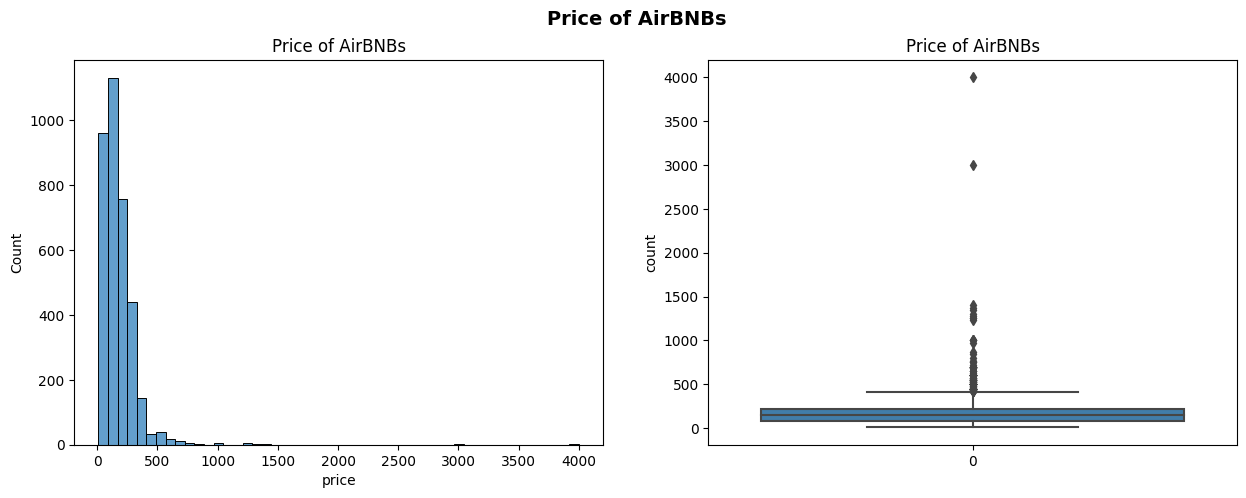

In [13]:
# Plot price using seaborn
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Price of AirBNBs', size = 14, weight = 'bold')

# histplot
sns.histplot(listings_df['price'],bins=50,ax=axes[0],color='#2F7FBC')
axes[0].set_title("Price of AirBNBs")

# Boxplot
sns.boxplot(listings_df['price'],ax=axes[1],color='#2F7FBC')
axes[1].set_title("Price of AirBNBs")
axes[1].set_ylabel("count");

In [14]:
print(f"Min listing price: {int(listings_df.price.min())} $.")
print(f"Max listing price: {int(listings_df.price.max())} $.")
print(f"Median listing price: {int(listings_df.price.median())} $.")

Min listing price: 10 $.
Max listing price: 4000 $.
Median listing price: 150 $.


> 🔑 **Note:** 
>* Prices range from `10$` to `4000$`. Median price is listed at `$150`.
>* Prices `500$` are outliers.

#### Explore numeric columns

Let's start by creating a function that returns % missing values and the number of unique values of a Pandas DataFrame.

In [15]:
def get_column_details(df,dtype=None):
    '''
    INPUT:
        df - a Pandas dataframe.
        dtype : Flag indicating which dtype to filter, default=None            
                possible values {'None', 'numeric', 'categorical'}.  
    
    OUTPUT:
        A dataFrame with columns: of % missing values and number of unique values.
    '''
    if dtype=="numeric":
        data = df.select_dtypes(include=["int64","float64","int32","float32"]).copy()
    elif dtype=="categorical":
        data = df.select_dtypes(include=["object"]).copy()
    else:
        data = df.copy()    
    
   
    missing_df = pd.DataFrame(100*data.isnull().mean().sort_values(ascending=False),columns=["% Missing values"])
    nunique_df = pd.DataFrame(data.nunique(),columns=["nunique"])
    
    return pd.merge(missing_df,nunique_df, left_index=True,right_index=True,how="inner")

In [16]:
# we will use the "get_column_details" function which returns %Missing values & nunique count for each column in the dataset

numeric_features_details = get_column_details(listings_df,"numeric") 
numeric_features_details = numeric_features_details.sort_values(by="% Missing values",ascending=False)
numeric_features_details

% Missing values  nunique
has_availability                      100.000000        0
jurisdiction_names                    100.000000        0
license                               100.000000        0
neighbourhood_group_cleansed          100.000000        0
square_feet                            98.425640       37
monthly_price                          75.428732      283
weekly_price                           75.035142      242
security_deposit                       62.412145       54
cleaning_fee                           30.728142       79
review_scores_accuracy                 22.968794        8
review_scores_location                 22.940680        9
review_scores_value                    22.912567        9
review_scores_checkin                  22.884453        8
review_scores_communication            22.828226        7
review_scores_cleanliness              22.828226        9
review_scores_rating                   22.659545       46
reviews_per_month                      21.085184      644
host_acceptance_rate                   13.185268       72
host_response_rate                     13.185268       52
price                                   0.000000      323
host_id                                 0.000000     2172
host_listings_count                     0.000000       35
host_total_listings_count               0.000000       35
latitude                                0.000000     3557
longitude                               0.000000     3557
accommodates                            0.000000       14
bathrooms                               0.000000        7
bedrooms                                0.000000        6
beds                                    0.000000       11
calculated_host_listings_count          0.000000       25
scrape_id                               0.000000        1
extra_people                            0.000000       51
minimum_nights                          0.000000       29
maximum_nights                          0.000000       85
id                                      0.000000     3557
availability_60                         0.000000       61
availability_90                         0.000000       91
availability_365                        0.000000      348
number_of_reviews                       0.000000      178
availability_30                         0.000000       31
guests_included                         0.000000       13

* Many features are correlated, such as review scores (communication, cleanliness...) and availability (30, 60, 90...).

* Columns with % of missing values>50% will be dropped.


Let's plot the **correlation matrix** of the numeric features.

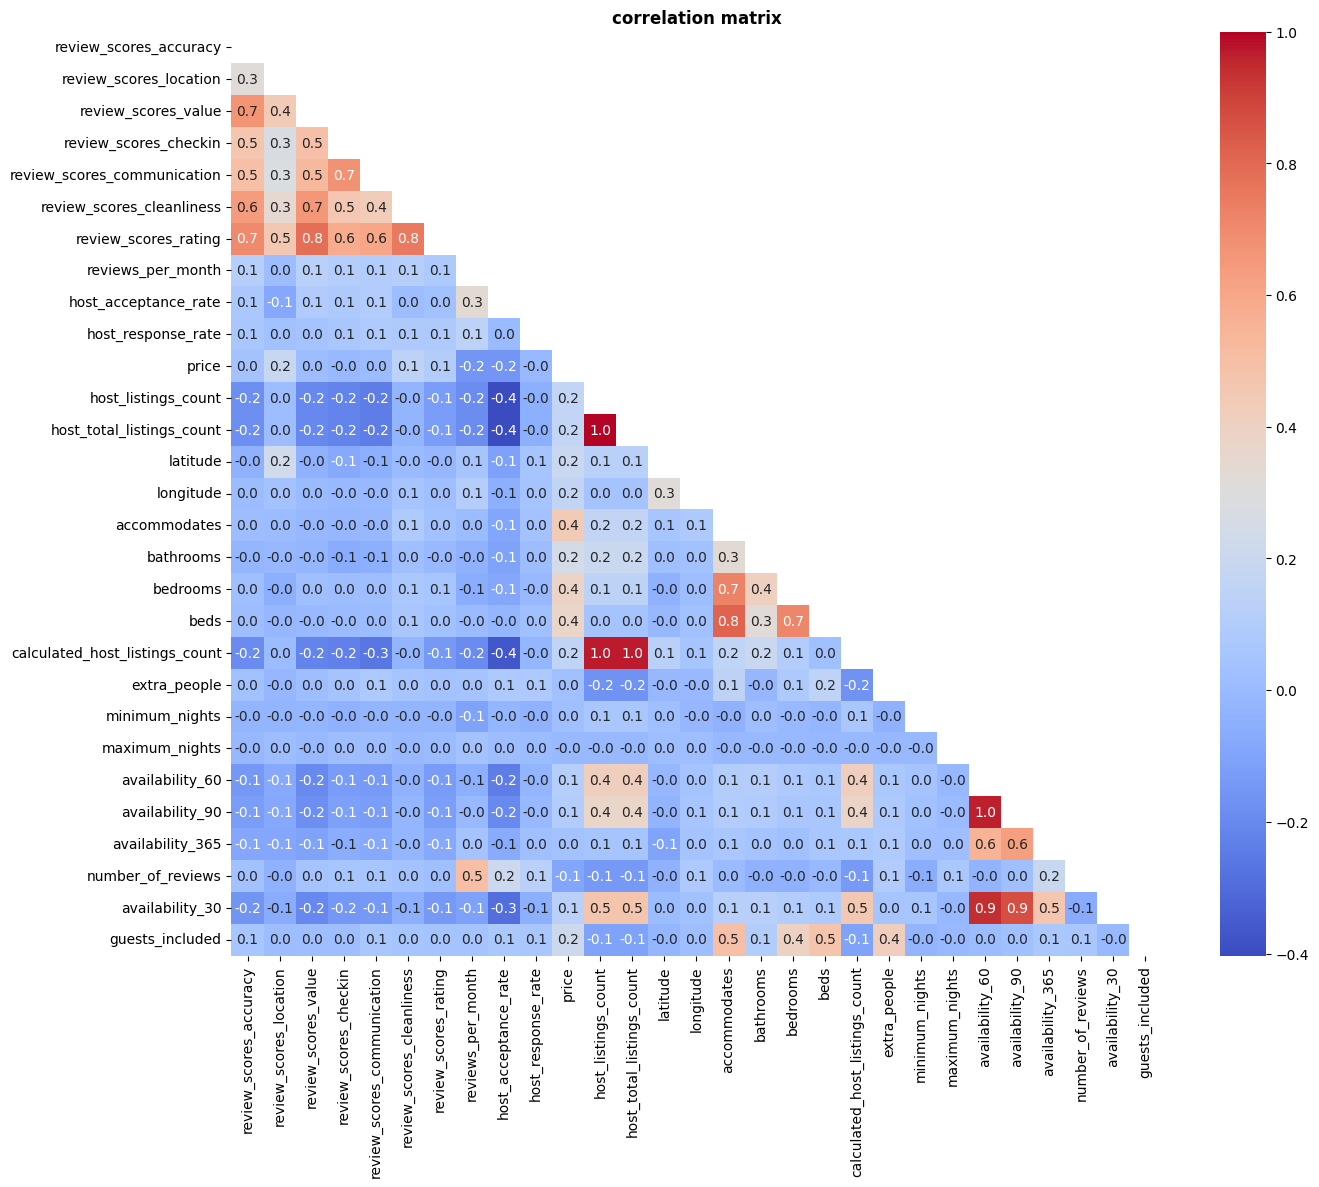

In [17]:
# numeric columns having % missing values <25%
columns = ['review_scores_accuracy', 'review_scores_location',
       'review_scores_value', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_cleanliness',
       'review_scores_rating', 'reviews_per_month', 'host_acceptance_rate',
       'host_response_rate', 'price',  'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'calculated_host_listings_count',
       'extra_people', 'minimum_nights', 'maximum_nights', 
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'availability_30', 'guests_included']

corr_matrix = listings_df[columns].corr(numeric_only=True)

# Let's plot Correlation Matrix 

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True    # data will not be shown in cells where `mask` is True

plt.figure(figsize=(15,12))    
sns.heatmap(corr_matrix,mask=mask,annot=True,fmt='.1f', cmap='coolwarm') 
plt.title("correlation matrix", size = 12, weight = 'bold');

> Unsurprisingly, price is highly correlated with beds, bedrooms, bathrooms and accomodates.

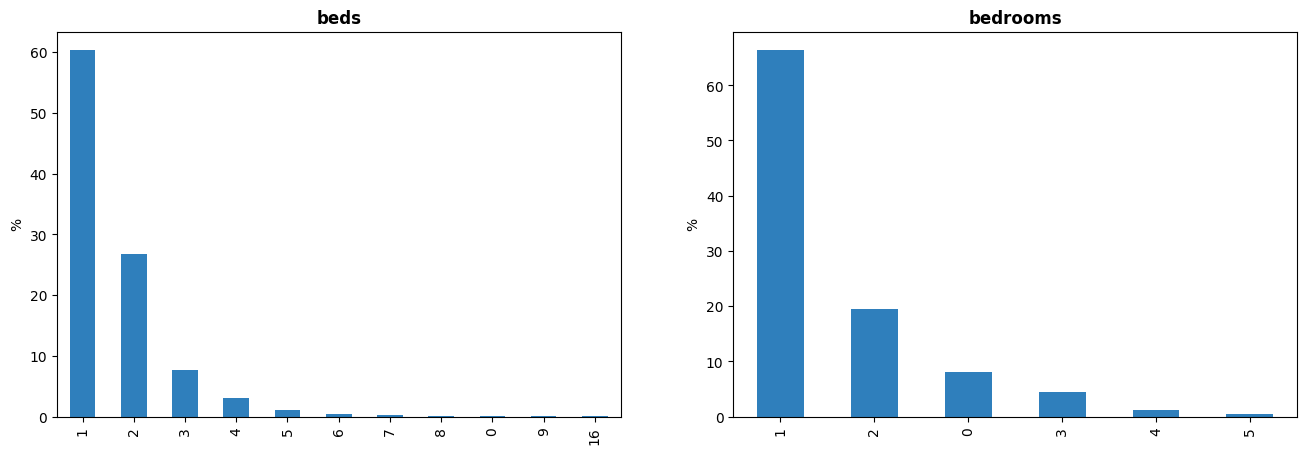

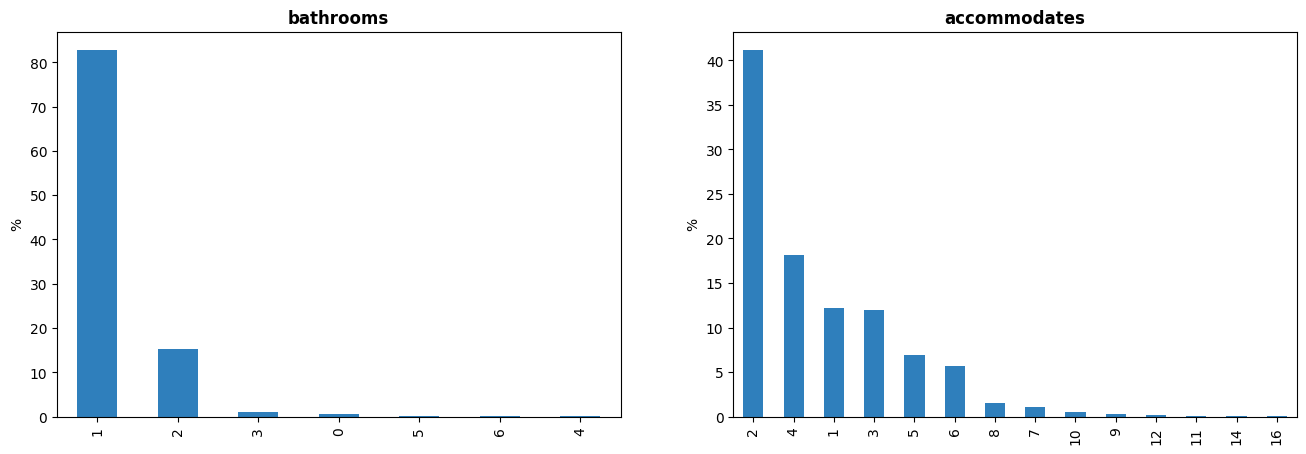

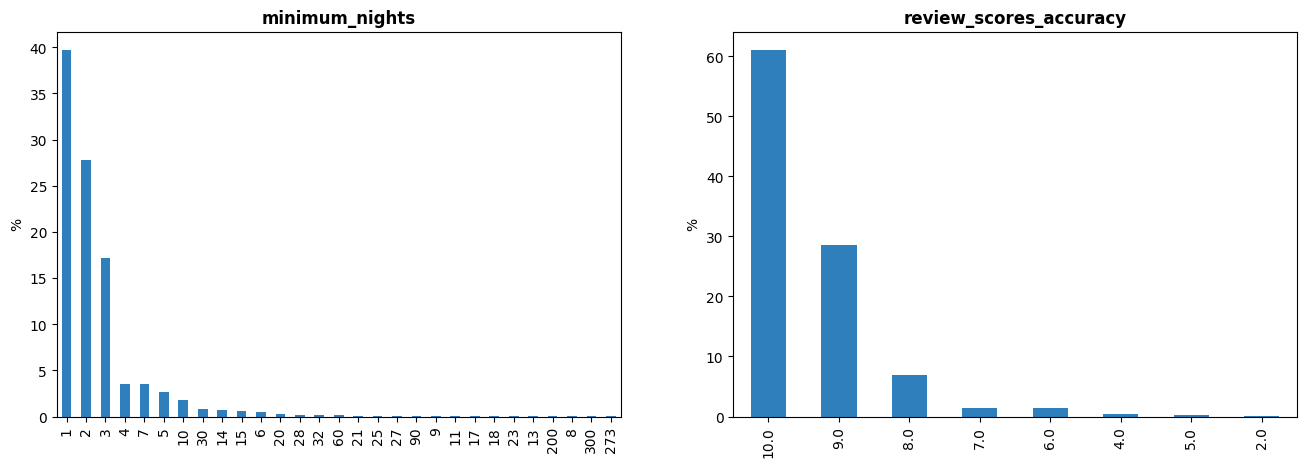

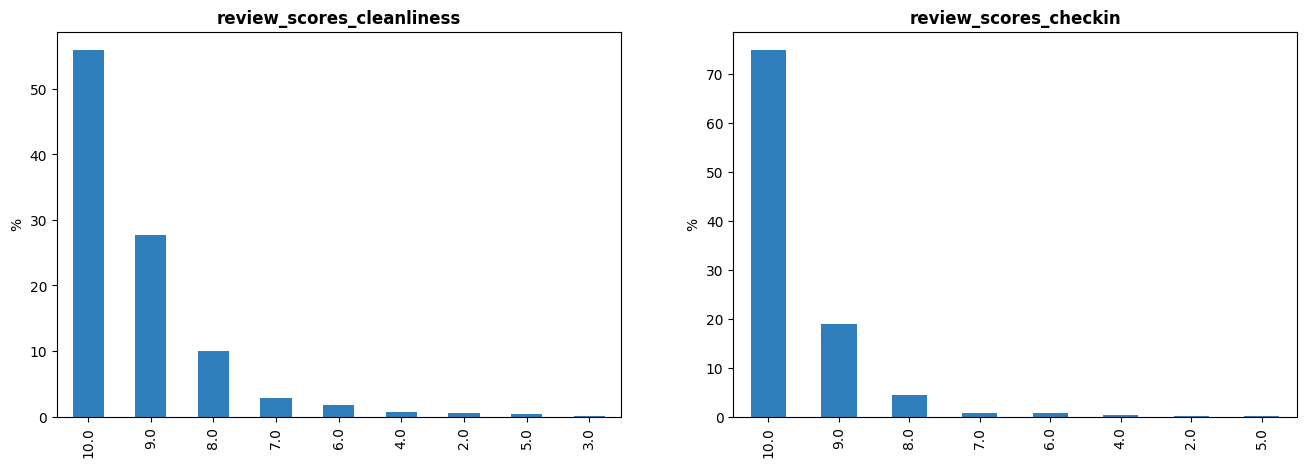

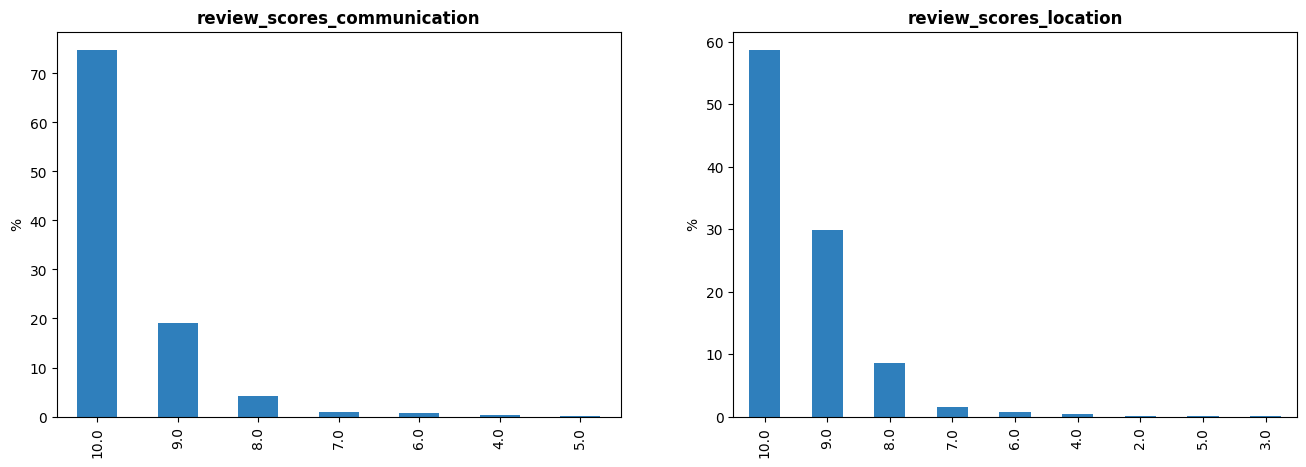

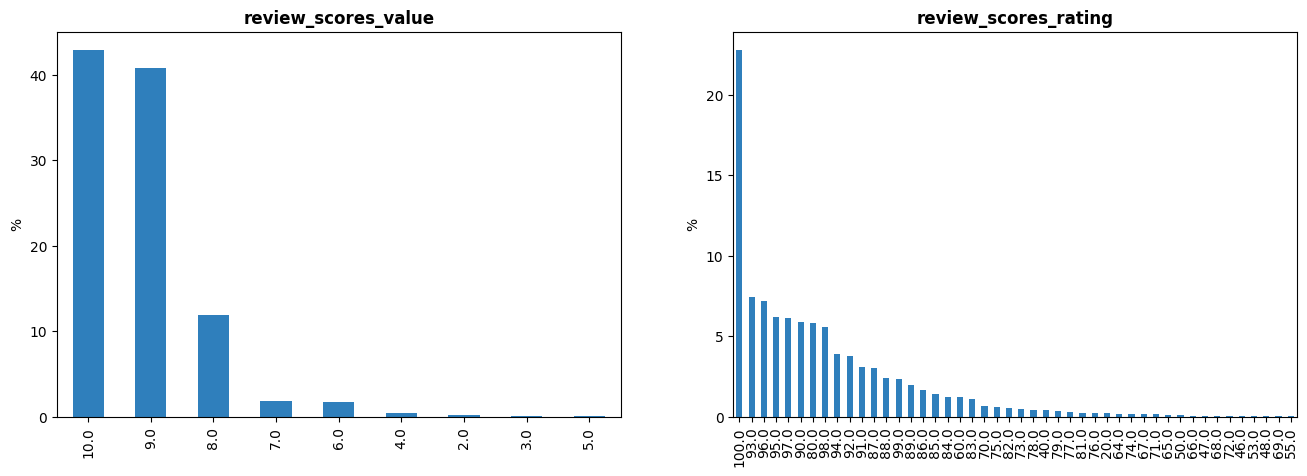

<Figure size 1600x500 with 0 Axes>

In [18]:
# Let's plot the ditribution of main numeric columns

features = ['beds','bedrooms','bathrooms','accommodates','minimum_nights',
            'review_scores_accuracy', 'review_scores_cleanliness',
            'review_scores_checkin', 'review_scores_communication',
            'review_scores_location','review_scores_value','review_scores_rating'
           ]

plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.2,hspace=0.2)
for k in range(len(features)):
    feature = features[k]    
    data = listings_df[feature].value_counts() 
    data = 100*data/data.sum() # convert value_counts to %
    
    plt.subplot(1,2,k%2+1)
    data.plot(kind = 'bar',color="#2F7FBC")
    plt.title(feature, weight = 'bold')
    plt.xlabel(None)
    plt.ylabel("%")
    if(len(data)>5):
        plt.xticks(rotation=90)
    else:
        plt.xticks(rotation=0) 
    
    if (k%2==1):
        plt.figure(figsize=(16,5))

> 🔑 **Insights:** 
> * **98%** of properties have less than 4 beds. 
> * **85%** of customers prefer 1 to 3 nights stay.
> * **95%** review scores are greater than 75.

#### Explore categorical columns

In [19]:
cat_columns_details = get_column_details(listings_df,"categorical") 
cat_columns_details = cat_columns_details.sort_values(by="% Missing values",ascending=False)
cat_columns_details

% Missing values  nunique
notes                                    54.905820     1264
interaction                              43.098116     1611
access                                   41.270734     1755
neighborhood_overview                    39.218443     1721
host_about                               36.603880     1236
transit                                  35.704245     1852
house_rules                              33.174023     1918
space                                    29.631712     2245
last_review                              21.085184      401
first_review                             21.085184      962
thumbnail_url                            16.643239     2965
medium_url                               16.643239     2965
xl_picture_url                           16.643239     2965
neighbourhood                            15.096992       30
host_response_time                       13.185268        4
host_neighbourhood                        9.389935       53
summary                                   3.542311     3104
zipcode                                   1.012089       43
market                                    0.393590        4
host_location                             0.309249      176
property_type                             0.084341       13
city                                      0.056227       38
neighbourhood_cleansed                    0.000000       25
description                               0.000000     3397
experiences_offered                       0.000000        1
picture_url                               0.000000     3557
host_url                                  0.000000     2172
host_name                                 0.000000     1331
host_is_superhost                         0.000000        2
host_thumbnail_url                        0.000000     2165
host_since                                0.000000     1277
host_picture_url                          0.000000     2165
last_scraped                              0.000000        1
host_has_profile_pic                      0.000000        2
host_identity_verified                    0.000000        2
street                                    0.000000     1233
name                                      0.000000     3476
room_type                                 0.000000        3
state                                     0.000000        1
host_verifications                        0.000000       83
listing_url                               0.000000     3557
requires_license                          0.000000        1
instant_bookable                          0.000000        2
calendar_updated                          0.000000       38
amenities                                 0.000000     3073
bed_type                                  0.000000        5
cancellation_policy                       0.000000        4
calendar_last_scraped                     0.000000        1
is_location_exact                         0.000000        2
country                                   0.000000        1
require_guest_profile_picture             0.000000        2
country_code                              0.000000        1
smart_location                            0.000000       39
require_guest_phone_verification          0.000000        2

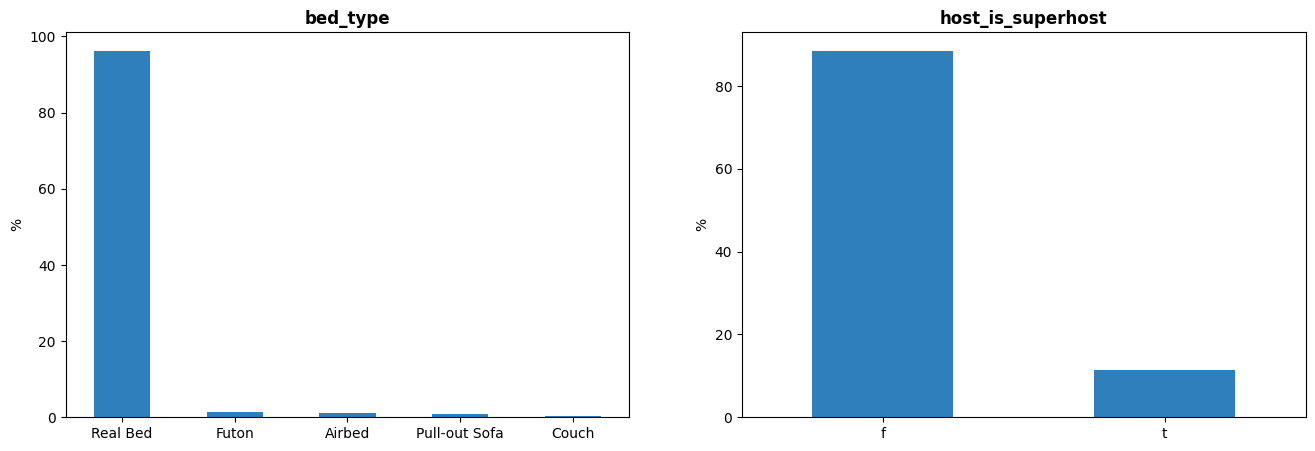

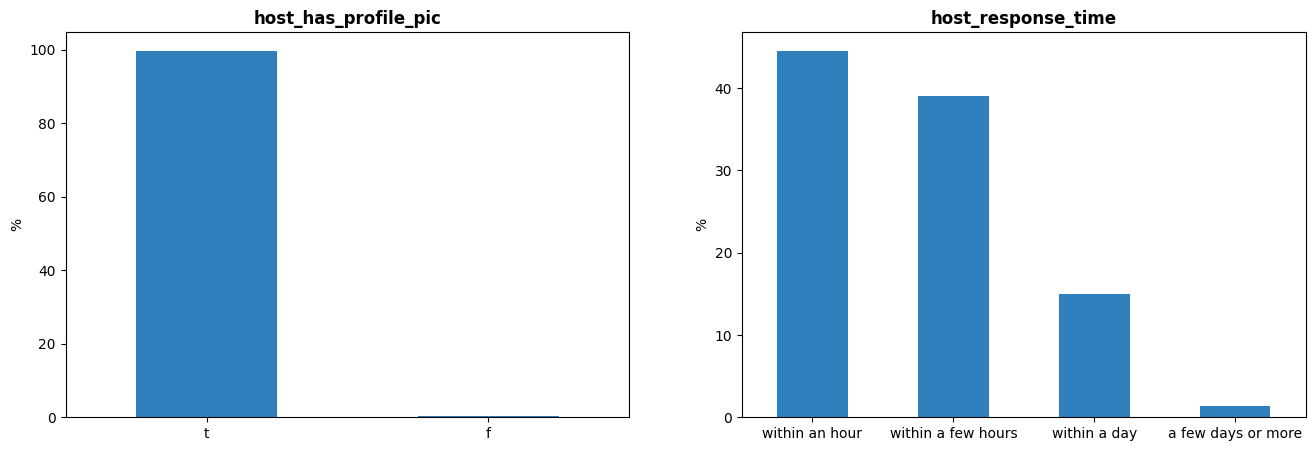

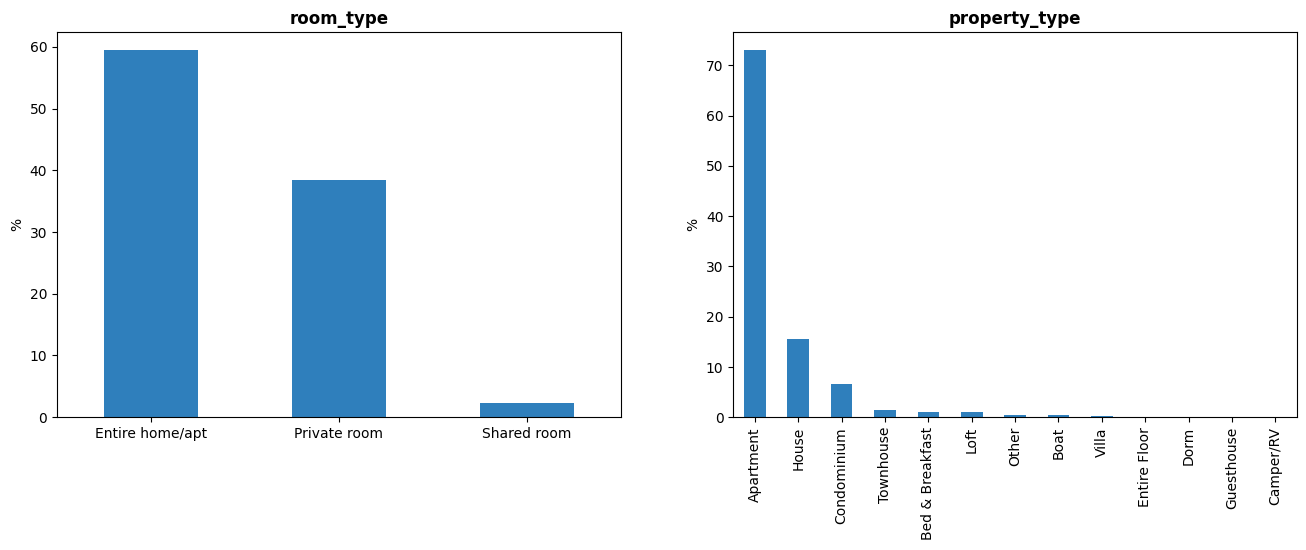

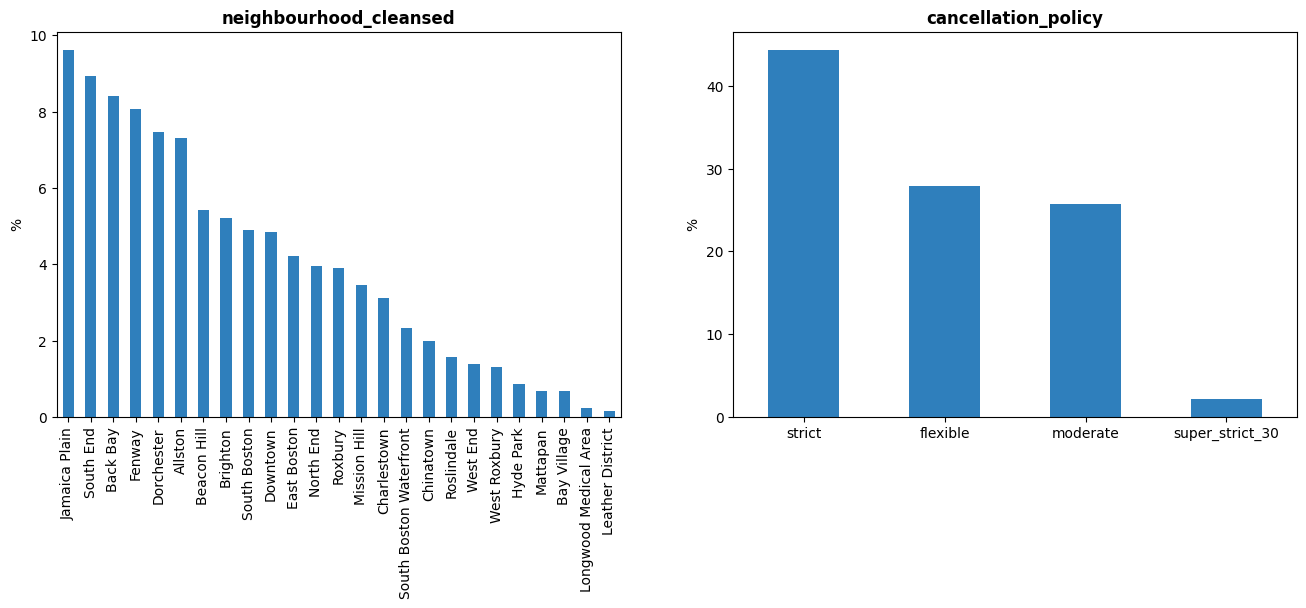

<Figure size 1600x500 with 0 Axes>

In [20]:
# Let's plot the distribution of the main categorical columns.

features = ['bed_type','host_is_superhost','host_has_profile_pic','host_response_time',
            'room_type','property_type','neighbourhood_cleansed','cancellation_policy']

plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.2,hspace=0.2)
for k in range(len(features)):
    feature = features[k]    
    data = listings_df[feature].value_counts() 
    data = 100*data/data.sum() # convert value_counts to value_percentage
    
    plt.subplot(1,2,k%2+1)
    data.plot(kind = 'bar',color="#2F7FBC")
    plt.title(feature, weight = 'bold')
    plt.xlabel(None)
    plt.ylabel("%")
    if(len(data)>5):
        plt.xticks(rotation=90)
    else:
        plt.xticks(rotation=0) 
    
    if (k%2==1):
        plt.figure(figsize=(16,5));

> 🔑 **Insights**
>* **58.5%** of visitors prefer Entire home/apt
>* **39%** of visitors prefer Private rooms with .

## Reviews data

In [21]:
reviews_df.sample(5)

listing_id        id        date  reviewer_id reviewer_name  \
14672     4577188  80636858  2016-06-19      1863703     Elizabeth   
40231      276450  12378534  2014-04-30        96714      Giovanni   
38617     9218362  84201667  2016-07-06     77946246         Kelly   
67022    12154934  78992190  2016-06-10     66242899         Qiyun   
13958      322593   5555222  2013-07-06      5381523       Nerissa   

                                                comments  
14672  The best thing about the apartment is definite...  
40231  The apartment was very clean and very well mai...  
38617  This apartment was perfect! It was beautifully...  
67022  The location is really convenient to get to ev...  
13958  This was my first experience with Airbnb and w...

### Look at the number of rows and columns

In [22]:
reviews_df.shape

(68275, 6)

### Check if there are missing values

In [23]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     68275 non-null  int64 
 1   id             68275 non-null  int64 
 2   date           68275 non-null  object
 3   reviewer_id    68275 non-null  int64 
 4   reviewer_name  68275 non-null  object
 5   comments       68222 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


# 2. Business undestanding

After looking at the data, the business questions we are trying to answer are:
    
>    1. How does **seasonality** impact Boston Airbnb pricing?
>    2. How does **location** impact Airbnb prices?
>    3. What are the **most important features** to predict Airbnb prices?
>    4. What is the relation between reviews and price?

# 3. Data Understanding

To get insights into our business questions, We will be using the Airbnb open dataset as follows:

1. How does seasonality affect AirBnB prices in Boston?

    We will use calendar data.  
 

2. How does location affect AirBnB prices? 

    We will use column neighbourhood_cleansed from listings data.

3. What are the most important features to predict AirBnB prices?

    We will use many columns from listings dataset and calendar dataset.

4. What is the relationship between reviews and price?

    We will use average review scores from listings dataframe and **Wordcloud** for review comments.

# 4. Question 1: How does seasonality impact Boston Airbnb pricing?

## Prepare Data: Gathering & Wrangling

In [24]:
# 1. Drop missing values
calendar_df = calendar_df.dropna(axis=0)

# 2. Split date to: year, month, day & dayofweek

calendar_df['Year'] = calendar_df['date'].dt.year
calendar_df['Month'] = calendar_df['date'].dt.month.astype(np.int64)
calendar_df['Day'] = calendar_df['date'].dt.day.astype(np.int64)
calendar_df['DayofWeek'] = calendar_df['date'].dt.dayofweek.astype(np.int64) #https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html


# 3. Create a Year_month column   

calendar_df["Year_Month"] = calendar_df["date"]
calendar_df["Year_Month"] = calendar_df["Year_Month"] .apply(lambda x:str(x)[:7])


# 4. Add a column to see if the datetime is a weekend or a weekday

def is_weekend(DayofWeek):
    if DayofWeek > 4:
        return 1
    else:
        return 0

calendar_df['weekend'] = np.vectorize(is_weekend)(calendar_df['DayofWeek'])

In [25]:
# 5. Create a dataframe to clculate availability of Airbnb houses (daily):

availability_data = calendar_df.groupby(['date','Year','Month','Day','DayofWeek','Year_Month','weekend']).agg({"price":"mean","listing_id":"count"}).reset_index()
availability_data = availability_data.rename(columns={'listing_id': 'count_listings_available'})
availability_data['total_listings'] = calendar_df.listing_id.nunique()
availability_data['availability'] = round(100*availability_data['count_listings_available']/availability_data['total_listings'],1)
availability_data.head()

date  Year  Month  Day  DayofWeek Year_Month  weekend       price  \
0 2016-09-06  2016      9    6          1    2016-09        0  241.043860   
1 2016-09-07  2016      9    7          2    2016-09        0  251.833691   
2 2016-09-08  2016      9    8          3    2016-09        0  251.748749   
3 2016-09-09  2016      9    9          4    2016-09        0  261.859327   
4 2016-09-10  2016      9   10          5    2016-09        1  266.847280   

   count_listings_available  total_listings  availability  
0                       570            2906          19.6  
1                       932            2906          32.1  
2                       999            2906          34.4  
3                       981            2906          33.8  
4                       956            2906          32.9

## Result Evaluation

Let's plot prices over years, months and weekends.

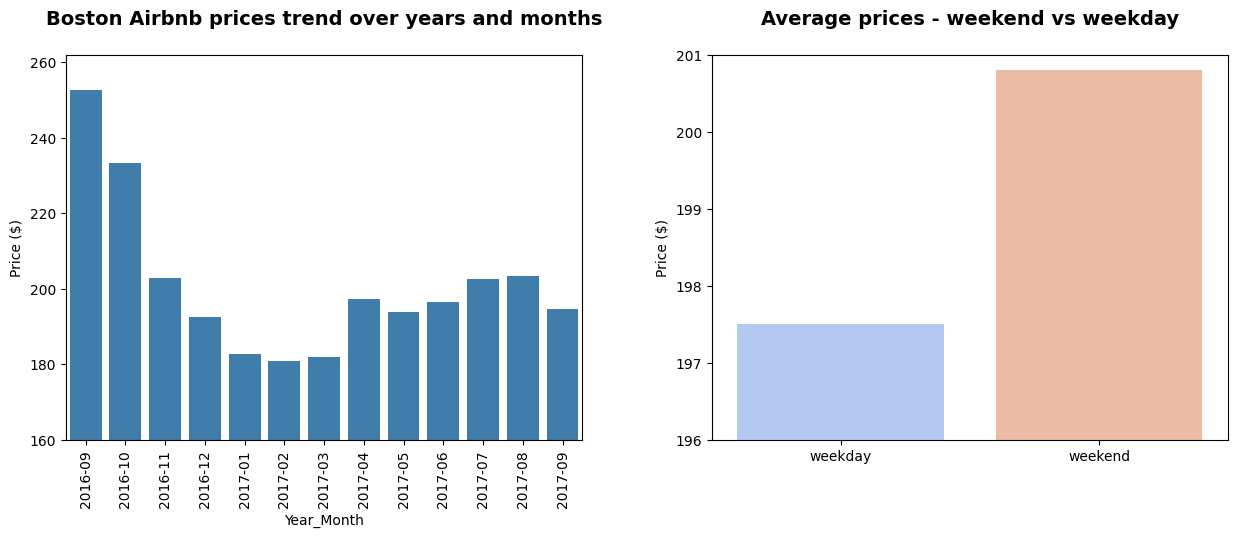

In [26]:
plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=.25,hspace=0)

# 1. Average prices trend over years and months
plt.subplot(1,2,1)
price_per_YearMonth = pd.DataFrame(calendar_df.groupby(['Year_Month']).mean(numeric_only=True)['price'].reset_index())
sns.barplot(data=price_per_YearMonth, x='Year_Month', y='price',color = '#2F7FBC') 
plt.ylim([int(price_per_YearMonth.price.min())-20,int(price_per_YearMonth.price.max())+10])
plt.xticks(rotation=90)
plt.ylabel("Price ($)")
plt.title('Boston Airbnb prices trend over years and months\n', size = 14, weight = 'bold')

# 2. Average Price Weekend vs Weekday
plt.subplot(1,2,2)
price_per_weekend = pd.DataFrame(calendar_df.groupby(['weekend']).mean(numeric_only=True)['price'].reset_index())
price_per_weekend.weekend = price_per_weekend.weekend.map({0:"weekday",1:"weekend"})
sns.barplot(data=price_per_weekend, x='weekend', y='price',palette="coolwarm")
plt.title('Average prices - weekend vs weekday\n', size = 14, weight = 'bold')
plt.xlabel(None)
plt.ylabel("Price ($)")
plt.ylim([int(price_per_weekend.price.min())-1,int(price_per_weekend.price.max())+1]);

**Seasonality effect on pricing:**

 * Max values are observed between September & October.
 * Min values are observed during the first quarter.

**Peaks (events):**

 * Peak around 2016-09-15 : Mid-Autumn Festival Celebration.
 * Peak around mid-April: Boston Marathon.

**periodic small peaks:** 

There are also periodic price increases on weekends compared to weekdays.

In [27]:
# Summary price statistics

price_offpeak = price_per_YearMonth[price_per_YearMonth['Year_Month'].isin(["2017-01","2017-02","2017-03"])].price.mean()
price_peak = price_per_YearMonth[price_per_YearMonth['Year_Month'].isin(["2016-09","2016-10"])].price.mean()

extra_weekend_mean = price_per_weekend.price.max()-price_per_weekend.price.min()
extra_weekend_peak = calendar_df[(calendar_df['Year_Month'].isin(["2016-09","2016-10"])) & (calendar_df.weekend==1)].price.mean()-\
                    calendar_df[(calendar_df['Year_Month'].isin(["2016-09","2016-10"])) & (calendar_df.weekend==0)].price.mean()

print(f"Averaga off-peak prices (first quarter) is: ${round(price_offpeak)}.")
print(f"Averaga in-peak prices (September & October) is: ${round(price_peak)}.\n")

print(f"Extra dollars due to weekend (from Sep.2016 to Sep.2017) is: ${round(extra_weekend_mean,1)}")
print(f"Extra dollars due to weekend (Sep.2016 & Oct.2016) is: ${round(extra_weekend_peak,1)}")

Averaga off-peak prices (first quarter) is: $182.
Averaga in-peak prices (September & October) is: $243.

Extra dollars due to weekend (from Sep.2016 to Sep.2017) is: $3.3
Extra dollars due to weekend (Sep.2016 & Oct.2016) is: $7.1


**Now let's plot house availability vs Price.**

We will create a dual axis chart with Plotly.

Reference : https://plotly.com/python/multiple-axes/

In [28]:
# Create figure with secondary y-axis

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=availability_data.date, y=availability_data.price, 
               marker={'color': "#2F7FBC"},
               name="Price ($)"
              ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=availability_data.date, y=availability_data.availability, 
               marker={'color': "#d8576b"},
               name="Availability (%)"
              ),
    secondary_y=True,
)

# update_layout
fig.update_layout(
    height = 650,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.075,
        xanchor="left",
        x=0
    ),
    title_text="<b>Average price vs availability</b>",
    title_x=0.5,
    font=dict(
        #family="Times New Roman",
        size=14,
        color="black" 
    ) 
)

# Set x-axis title
fig.update_xaxes(title_text="Date",tickangle=-90)

# Set y-axes titles & colors
fig.update_yaxes(title_text="Average Price ($)", color = '#2F7FBC',secondary_y=False)
fig.update_yaxes(title_text="Availability (%)",color = "#d8576b",secondary_y=True)

# Update Showgrid
fig['layout']['yaxis2']['showgrid'] = False
fig['layout']['yaxis1']['showgrid'] = True
fig['layout']['xaxis']['showgrid'] = True

fig.show();

> 🔑 **Insights** 
>
> * Availability is stable from November to February, with an average of **70%**. 
> * Availability is stable from Mars to August, with an average of **60%**.
> * Increasing trend of availabilty from Septemeber to Novemeber (from **30%** to **70%**).

# 5. Question 2: How does location impact Airbnb prices?

## Prepare Data: Gathering & Wrangling

Let's start by creating a function that calculates the distance between two coordinates.

Reference could be found [here](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points)

This function will be used to calculate the distance to city centre.

In [29]:
from math import radians, cos, sin, asin, sqrt
def distance_haversine(lon1, lat1, lon2, lat2):    
    """
    Calculate the distance (in Km) between two coordinates (lon1,lat1) and (lon2,lat2)    
    INPUT: two coordinates (lon1,lat1) and (lon2,lat2)
    OUTPUT: distance in Km
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers = 6371
    km = 6371* c
    return km

In [30]:
# 1. We will create a dataframe (neighbourhood_price) with the following columns:

columns = ['id','latitude', 'longitude','price',
           'neighbourhood_cleansed','property_type', 'room_type', 'accommodates',
           'bathrooms', 'bedrooms', 'beds', 'bed_type',
           'number_of_reviews','host_total_listings_count',
           'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
           'review_scores_checkin', 'review_scores_communication','review_scores_location',
            'review_scores_value']

neighbourhood_price = listings_df[columns].copy()

neighbourhood_price["review_scores_rating"] = neighbourhood_price["review_scores_rating"]/10

# 2. Remove price outliers:
neighbourhood_price = neighbourhood_price[neighbourhood_price.price<500]

# 2. Add column: distance_to_downtown (Km)
downtown_longitude = -71.057083
downtown_latitude = 42.361145

# Use the "distance_haversine" function to calculate the distance to downtown
neighbourhood_price["distance_to_downtown"] = np.vectorize(distance_haversine)(neighbourhood_price.longitude,neighbourhood_price.latitude,\
                                                              downtown_longitude,downtown_latitude)

# 3. create a price_range column (10 percentiles)
price_pecentiles = [np.percentile(listings_df['price'],i).astype(np.int64) for i in range(0,101,11)]
price_pecentiles.insert(0,0)

neighbourhood_price['price_range'] = pd.cut(neighbourhood_price['price'], 
                                    price_pecentiles, 
                                    labels=price_pecentiles[1:])

## Result Evaluation

Let's plot price by x & y coordinates:

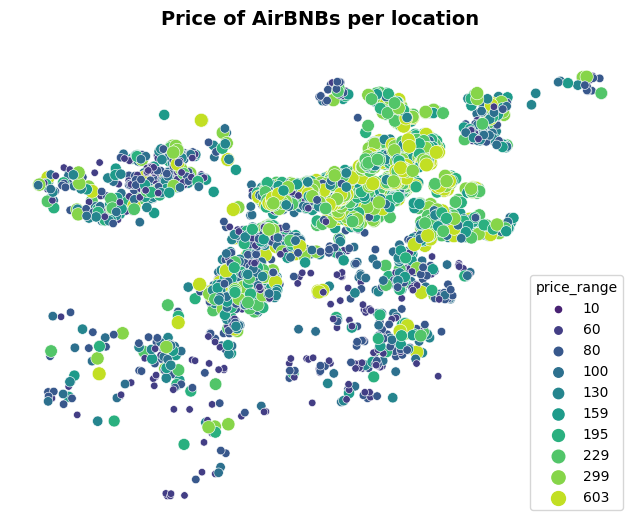

In [31]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=neighbourhood_price, x = "longitude", y="latitude",
                hue="price_range",
                palette="viridis"
                ,size="price_range", sizes=(100, 20)
               )
plt.title("Price of AirBNBs per location\n", size = 14, weight = 'bold')
plt.axis("off") ;

We can see that prices are higher for locations closer to the city centre.

**Average Price by neighbourhood**

In [32]:
# create a recap table per neighbourhood
recap_neighbourhood = neighbourhood_price.groupby("neighbourhood_cleansed").\
                        mean(numeric_only=True)[["price","distance_to_downtown",
                                                 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
                                                 'review_scores_checkin', 'review_scores_communication',
                                                 'review_scores_location','review_scores_value']].\
                        reset_index()
recap_neighbourhood = recap_neighbourhood.sort_values("price",ascending=False)
recap_neighbourhood

neighbourhood_cleansed       price  distance_to_downtown  \
13         Leather District  253.600000              1.105546   
21  South Boston Waterfront  234.256757              1.715416   
6                 Chinatown  232.352113              1.239107   
8                  Downtown  230.893491              0.785824   
1                  Back Bay  225.442907              2.391967   
23                 West End  209.591837              0.986854   
2               Bay Village  205.473684              1.619327   
3               Beacon Hill  193.601093              0.925699   
17                North End  192.007194              0.542394   
10                   Fenway  190.158273              3.676084   
22                South End  186.683007              2.540138   
5               Charlestown  175.509434              2.261023   
20             South Boston  167.132530              3.092406   
14    Longwood Medical Area  148.250000              4.785814   
19                  Roxbury  128.577778              4.408773   
12            Jamaica Plain  128.332335              7.016549   
9               East Boston  119.153333              2.694433   
16             Mission Hill  116.008197              5.030323   
4                  Brighton  111.874317              7.841523   
0                   Allston  109.015504              6.118230   
24             West Roxbury  107.108696             11.989878   
18               Roslindale   98.428571             10.486265   
7                Dorchester   92.045113              6.372098   
11                Hyde Park   86.548387             12.836620   
15                 Mattapan   75.125000              9.720780   

    review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
13              9.833333               10.000000                  10.000000   
21              9.430769                9.692308                   9.692308   
6               9.212195                9.365854                   9.365854   
8               9.245299                9.350427                   9.410256   
1               9.152193                9.339207                   9.303965   
23              9.033333                8.925926                   9.111111   
2               9.415385                9.307692                   9.461538   
3               9.317500                9.427673                   9.333333   
17              9.371186                9.525424                   9.322034   
10              8.930769                9.244444                   8.927778   
22              9.325296                9.517787                   9.482213   
5               9.367123                9.589041                   9.424658   
20              9.398630                9.664384                   9.582192   
14              9.400000                9.666667                   9.333333   
19              9.026126                9.354545                   9.180180   
12              9.420486                9.685315                   9.423611   
9               9.027206                9.360294                   9.161765   
16              8.754321                9.237500                   8.617284   
4               9.079545                9.378788                   9.083333   
0               9.019337                9.294444                   8.983425   
24              9.521212                9.636364                   9.696970   
18              9.538000                9.760000                   9.660000   
7               8.928378                9.300000                   8.981818   
11              9.228000                9.400000                   9.080000   
15              9.100000                9.277778                   8.777778   

    review_scores_checkin  review_scores_communication  \
13              10.000000                    10.000000   
21               9.576923                     9.634615   
6                9.439024                     9.560976   
8                9.555556  

In [33]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x = recap_neighbourhood.neighbourhood_cleansed, y = recap_neighbourhood.distance_to_downtown,
               line=dict(color="#2F7FBC",width=3),
               mode="lines+markers",
               name="Distance (Km)"
              ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = recap_neighbourhood.neighbourhood_cleansed, y = recap_neighbourhood.price, 
               line=dict(color="#d8576b",width=3),
               mode="lines+markers",
               name="Price ($)"
              ),
    secondary_y=True,
)

# update_layout
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.09,
        xanchor="left",
        x=0
    ),
    title_text="<b>Average price by neighbourhood</b>",
    title_x=0.5, 
    height=700,
    font=dict(
        #family="Times New Roman",
        size=14,
        color="black"  
    )   
)

# Set x-axis title
fig.update_xaxes(title_text="",tickangle=-90, type = 'category')

# Set y-axes titles & colors
fig.update_yaxes(title_text="Diatance (Km)", color = '#2F7FBC',secondary_y=False)
fig.update_yaxes(title_text="Average Price ($)",color = "#d8576b",secondary_y=True)

# update showgrid
fig['layout']['yaxis2']['showgrid'] = False
fig['layout']['yaxis1']['showgrid'] = True
fig['layout']['xaxis']['showgrid'] = False

fig.show();

> 🔑 **Insights:** 
> The average price and distance to downtown are correlated;
 prices tend to decrease as distance from the city center increases. 
> 
> For instance, locations such as Hyde Park or Roslindale, which are more than 10 km far from downtown, are the cheapest at around `$98` per day.
> 
> At less than 2 Km from downtown and costing more than `$200` per day, the most expensive locations are: Leather District, South Boston Waterfront, Chinatown, Downtown, Back Bay, West End and Bay Village.




  


**Heatmap of price  per room/property type vs Neighbourhood**

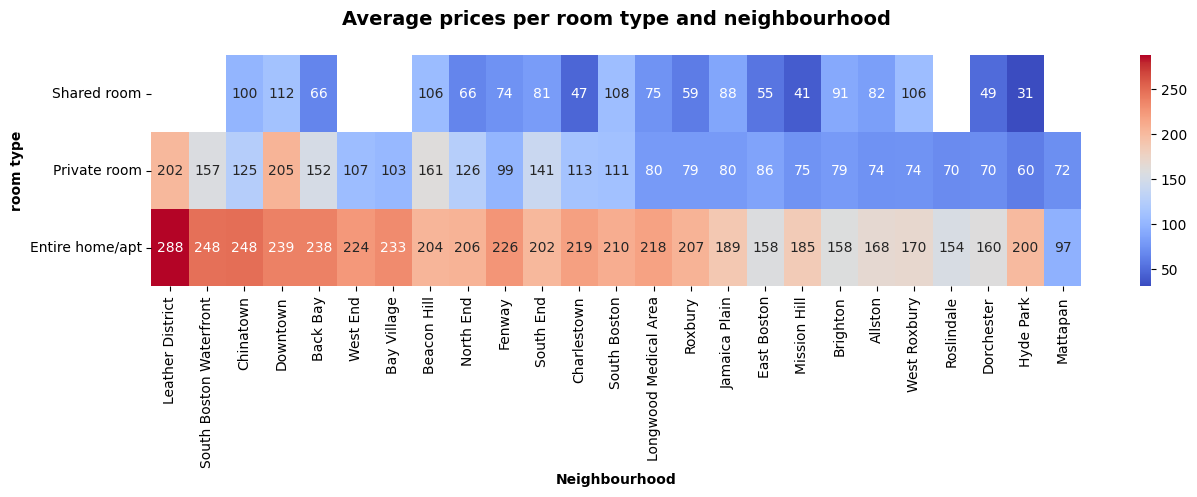

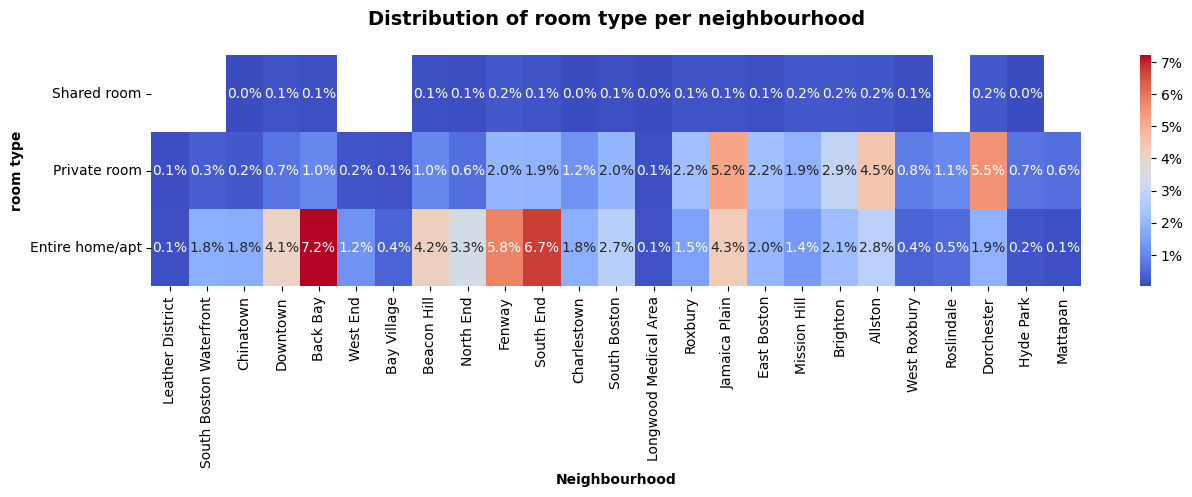

<Figure size 1600x400 with 0 Axes>

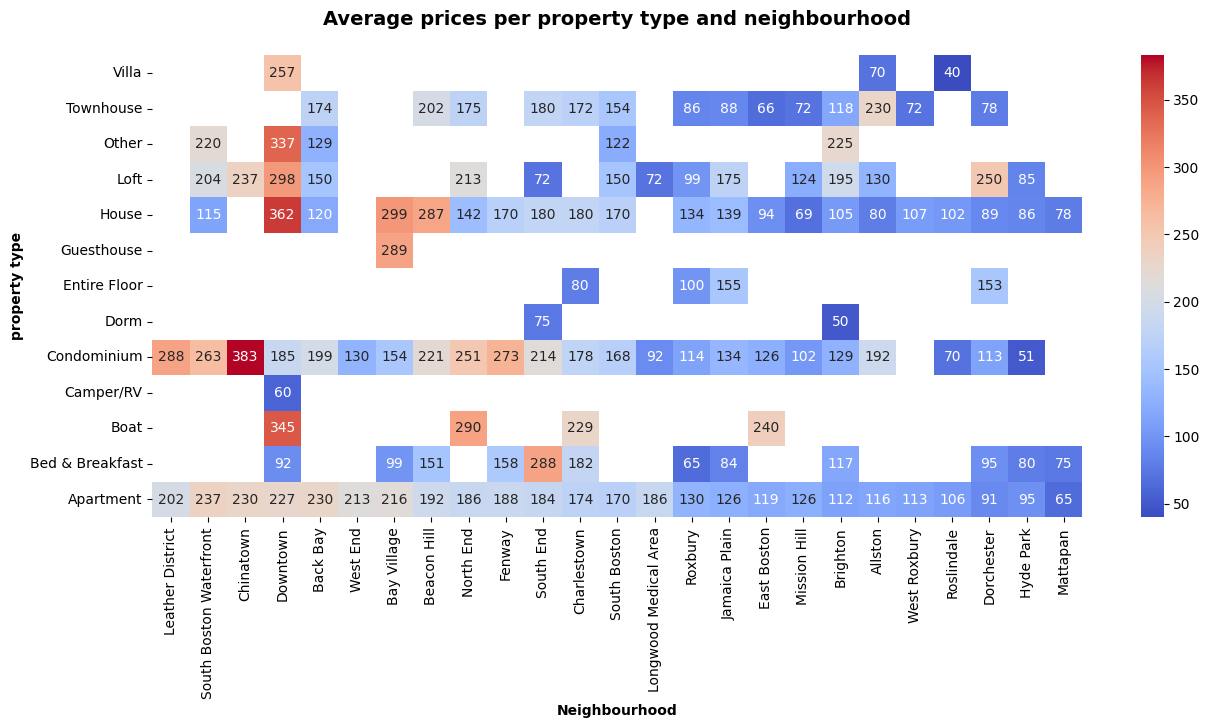

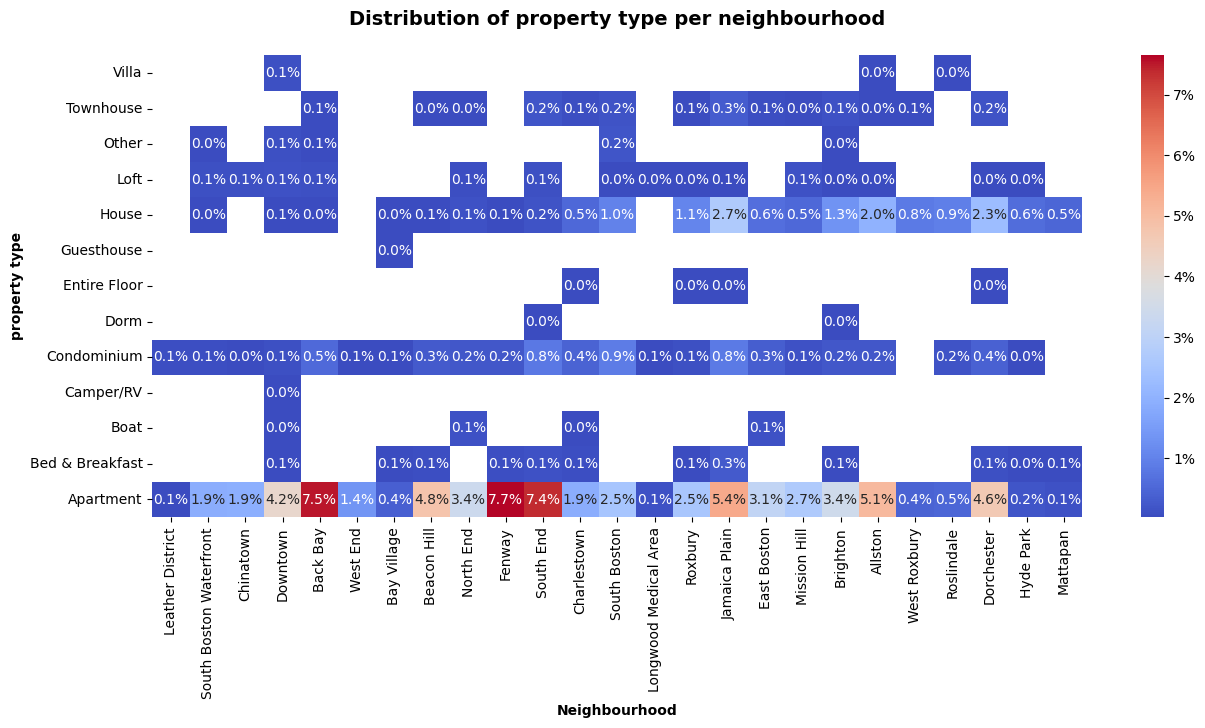

<Figure size 1600x400 with 0 Axes>

In [67]:
features = ['room_type','property_type']

for feature in features:
    # 1. create a pivot table : avg price 
    table = neighbourhood_price.pivot_table(values="price", 
                           index=feature, 
                           columns="neighbourhood_cleansed",
                           aggfunc="mean").sort_values(by=feature,ascending=False)
    table = table[recap_neighbourhood.neighbourhood_cleansed]   
    
    #set the heigh of the plot according to number of features        
    if table.shape[0]<4:
        plt.figure(figsize=(15,3))
    else:
        plt.figure(figsize=(15,6))
        
    sns.heatmap(table, fmt='.0f', annot=True,cmap="coolwarm")
    plt.title(f"Average prices per {feature.replace('_',' ')} and neighbourhood\n",size = 14, weight = 'bold')
    plt.xlabel("Neighbourhood", weight = 'bold')
    plt.ylabel(feature.replace('_',' '), weight = 'bold')
    
        
    # 2. create a pivot table : count of listings    
    table2 = neighbourhood_price.pivot_table(values="id", 
                               index=feature, 
                               columns="neighbourhood_cleansed",
                               aggfunc="count").sort_values(by=feature,ascending=False)
    table2 = 100*table2/np.sum(table2.sum()) # calculate %
    table2 = table2[recap_neighbourhood.neighbourhood_cleansed]
    
    #set the heigh of the plot according to number of features        
    if table2.shape[0]<4:
        plt.figure(figsize=(15,3))
    else:
        plt.figure(figsize=(15,6))
        
    ax = sns.heatmap(table2, cmap="coolwarm", fmt='.1f', annot=True,cbar_kws={'format': '%.0f%%'})
    
    # add (%) to heatmap annotation 
    for t in ax.texts: t.set_text(t.get_text() + "%") #https://stackoverflow.com/questions/37602885/adding-units-to-heatmap-annotation-in-seaborn
    plt.title(f"Distribution of {feature.replace('_',' ')} per neighbourhood\n", size = 14, weight = 'bold') 
    plt.xlabel("Neighbourhood", weight = 'bold')
    plt.ylabel(feature.replace('_',' '), weight = 'bold')
    
    plt.figure(figsize=(16,4));

In [35]:
# Entire home/apt stats:
enire_home_stats = neighbourhood_price[neighbourhood_price.room_type=="Entire home/apt"].groupby("neighbourhood_cleansed")\
.agg({"price":"mean","distance_to_downtown":"mean","id":"count"})\
.reset_index().sort_values(by="distance_to_downtown",ascending=False)

enire_home_stats.columns=["neighbourhood_cleansed","price","distance_to_downtown","listings_count"]
enire_home_stats

neighbourhood_cleansed       price  distance_to_downtown  listings_count
11                Hyde Park  200.500000             12.590860               6
24             West Roxbury  170.466667             11.636019              15
18               Roslindale  153.736842             10.469513              19
15                 Mattapan   96.666667              9.689496               3
4                  Brighton  158.500000              8.105112              74
12            Jamaica Plain  188.583893              6.934475             149
7                Dorchester  160.272727              6.304841              66
0                   Allston  167.979167              6.085699              96
16             Mission Hill  185.416667              4.954912              48
14    Longwood Medical Area  217.750000              4.720787               4
19                  Roxbury  206.622642              4.224769              53
10                   Fenway  225.945274              3.733430             201
20             South Boston  210.382979              3.117272              94
9               East Boston  158.285714              2.696054              70
22                South End  202.038462              2.521431             234
1                  Back Bay  237.884000              2.373209             250
5               Charlestown  219.174603              2.039338              63
21  South Boston Waterfront  247.666667              1.682695              63
2               Bay Village  232.733333              1.633771              15
6                 Chinatown  248.306452              1.228833              62
13         Leather District  288.000000              1.082284               3
23                 West End  223.930233              0.981914              43
3               Beacon Hill  203.694444              0.919700             144
8                  Downtown  238.617021              0.791403             141
17                North End  206.172414              0.538736             116

In [36]:
# Private room stats
private_room_stats = neighbourhood_price[neighbourhood_price.room_type=="Private room"].groupby("neighbourhood_cleansed")\
.agg({"price":"mean","distance_to_downtown":"mean","id":"count"})\
.reset_index().sort_values(by="distance_to_downtown",ascending=False)

private_room_stats.columns=["neighbourhood_cleansed","price","distance_to_downtown","listings_count"]
private_room_stats

neighbourhood_cleansed       price  distance_to_downtown  listings_count
11                Hyde Park   60.375000             12.797918              24
24             West Roxbury   74.379310             12.148787              29
18               Roslindale   70.027027             10.494868              37
15                 Mattapan   72.047619              9.725250              21
4                  Brighton   79.490196              7.673627             102
12            Jamaica Plain   79.572222              7.091224             180
7                Dorchester   70.375000              6.377837             192
0                   Allston   73.756410              6.135639             156
16             Mission Hill   74.636364              5.116903              66
14    Longwood Medical Area   80.000000              5.019711               3
19                  Roxbury   79.350649              4.482190              77
10                   Fenway   99.362319              3.526300              69
20             South Boston  110.797101              3.061142              69
9               East Boston   86.064935              2.722035              77
22                South End  140.955224              2.606764              67
5               Charlestown  113.071429              2.561878              42
1                  Back Bay  152.333333              2.520446              36
21  South Boston Waterfront  157.454545              1.902819              11
2               Bay Village  103.250000              1.565162               4
6                 Chinatown  125.250000              1.305635               8
13         Leather District  202.000000              1.140439               2
23                 West End  106.833333              1.022261               6
3               Beacon Hill  160.527778              0.953974              36
8                  Downtown  205.375000              0.700186              24
17                North End  125.761905              0.552971              21

> 🔑 **Insights:** 
>* Prices for the entire houses or apartments are the highest.
>* Excluding Hide Park, the cheapest at `$60`, if the distance to the city centre is greater than 4.5 Km, prices range from `$70` to `$80`. 
>* For areas closer to downtown (14 neighbourhoods), there is a wide range of prices from `$85` to `$160`. The highest prices are in Downtown and the Leather District at around $205.


# 6. Question 3: What are the most important features to predict Airbnb prices?

## Data Preparation

* Drop columns with more than 50% null values.
* Drop columns with only one value.
* Drop columns containing name, URLs & IDs
* Remove price outliers: drop all rows with price >500.

In [37]:
dropped_columns = []

# 1.  Drop columns with more than 50% null values

listings_df_null = listings_df.isnull().mean()
columns_more_than_50_null = listings_df.columns[listings_df_null >0.5]
for column in columns_more_than_50_null:
    try:
        listings_df = listings_df.drop(column, axis=1)
        dropped_columns.append(column)
    except:
        pass

# 2. Drop columns with only one value

columns_one_value = [column for column in listings_df.columns if listings_df[column].nunique() == 1]
for column in columns_one_value:
    try:
        listings_df = listings_df.drop(column, axis=1)
        dropped_columns.append(column)
    except:
        pass

# 3. drop columns containing name, URLs & IDs

columns_URL_IDs = listings_df.columns[listings_df.columns.str.contains('url|_id|name')]
for column in columns_URL_IDs:
    try:
        listings_df = listings_df.drop(column, axis=1)
        dropped_columns.append(column)
    except:
        pass

# 4. print dropped columns
if len(dropped_columns):
    print(f"\n\n{len(dropped_columns)} dropped columns:")
    print(dropped_columns)
    
# 5. Remove price outliers
listings_df = listings_df[listings_df['price'] < 500]

# 6. remove all rows with missing values for columns: bathrooms, bedrooms and beds
listings_df.dropna(axis=0, subset=["bathrooms", "bedrooms", "beds"], inplace=True)

# 7. convert columns(bathrooms, bedrooms and beds) to int

for column in ["bathrooms", "bedrooms", "beds"]:
    if (~(listings_df[column].dtype==np.int64)):
        listings_df[column] = listings_df[column].astype(np.int64)



29 dropped columns:
['notes', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'security_deposit', 'has_availability', 'license', 'jurisdiction_names', 'scrape_id', 'last_scraped', 'experiences_offered', 'state', 'country_code', 'country', 'calendar_last_scraped', 'requires_license', 'listing_url', 'name', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url', 'host_identity_verified']


### Feature engineering

* Host_location will be set to 0 or 1. (1 if Host Location = "Boston, Massachusetts.  Else 0)
* Create a column host_verifications_count. Counts the number of host verifications.
* Add a column for each amenity.

**Host_Location**

In [38]:
# Distribution of Host_Location (%)
100*(listings_df['host_location'].value_counts()/listings_df['host_location'].value_counts().sum())

Boston, Massachusetts, United States              67.997685
US                                                14.265046
New York, New York, United States                  3.067130
Montreal, Quebec, Canada                           1.707176
Middlesex County, Massachusetts, United States     1.446759
                                                    ...    
San Diego, California, United States               0.028935
Munich, Bavaria, Germany                           0.028935
USA                                                0.028935
Tel-Aviv, Israel                                   0.028935
Ashland, Massachusetts, United States              0.028935
Name: host_location, Length: 172, dtype: float64

In [39]:
# if Host Location = "Boston, Massachusetts, United States" then return 1, else return 0

function = lambda location: 1 if location=="Boston, Massachusetts, United States" else 0

listings_df['host_location'] = listings_df['host_location'].apply(function)

**Host verification**

In [40]:
# distribution of Host verification (#)
listings_df.host_verifications.value_counts()

['email', 'phone', 'reviews', 'jumio']                                  906
['email', 'phone', 'reviews', 'kba']                                    743
['email', 'phone', 'reviews']                                           591
['email', 'phone', 'facebook', 'reviews', 'kba']                        213
['email', 'phone', 'facebook', 'reviews', 'jumio']                      197
                                                                       ... 
['email', 'phone', 'facebook', 'reviews', 'manual_offline', 'jumio']      1
['email', 'phone', 'manual_offline', 'jumio']                             1
['email', 'phone', 'linkedin', 'amex', 'reviews', 'jumio']                1
['email', 'phone', 'amex', 'kba']                                         1
[]                                                                        1
Name: host_verifications, Length: 82, dtype: int64

In [41]:
#   create a column host_verifications_count counting the number of host verifications (email, phone, linkedin...)
listings_df['host_verifications_count'] = listings_df.host_verifications.str.count(',')+1

**Amenities**

In [42]:
# distribution of amenities (#)
listings_df.amenities.value_counts()[:5]

{}                                                                                                                                                                                                                                                                                                                  28
{TV,"Cable TV","Wireless Internet","Air Conditioning",Kitchen,Heating,Washer,Dryer,"translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}                                                                                                                                       15
{TV,"Cable TV","Wireless Internet","Air Conditioning",Kitchen,Heating,Washer,Dryer,"Smoke Detector","Fire Extinguisher","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}                                                                                                  14
{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitc

In [43]:
# Add column for each amenity

listings_df["amenities"] = listings_df["amenities"].map(lambda x: x.replace("{",""),na_action='ignore')
listings_df["amenities"] = listings_df["amenities"].map(lambda x: x.replace("}",""),na_action='ignore')


def split_amenities(amenities,splitter=","):
    '''
    INPUT:
        amenities - a Pandas Series.
        splitter - String. default = ","
    
    
    OUTPUT:
        A Pandas series containing the unique values and their counts.
    '''
    list_split = []
    for k in range(len(amenities)):
        column_split = amenities.iloc[k].split(splitter)
        for j in range(len(column_split)):
            if len(column_split[j])>0:
                list_split.append(column_split[j])
        
    list_split = pd.Series(list_split)
    unique_values =  list_split.value_counts()   
    return unique_values

amenities = split_amenities(listings_df.amenities,",")


counter = 0 # counts the number of added columns
def check_isin(string1,string2):
    """
    check if string1 is in string2
    """
    s1 = string1+","
    s2 = ","+string1
    if (s1 in string2) or (s2 in string2):
        return 1
    else:
        return 0

for column in amenities.index:    
    column_name = "amenities "+column
    column_name = column_name.replace('"','')
    try:
        listings_df[column_name] = column
        listings_df[column_name] = np.vectorize(check_isin)(listings_df[column_name], listings_df["amenities"])
        counter += 1
    except:
        pass
    
amenities.index =  amenities.index.str.replace('"','') # remove " from amenities.index

print(f"{counter} amenities are found. A column is created for each amenity.")

45 amenities are found. A column is created for each amenity.


**What are the top provided amenities?**

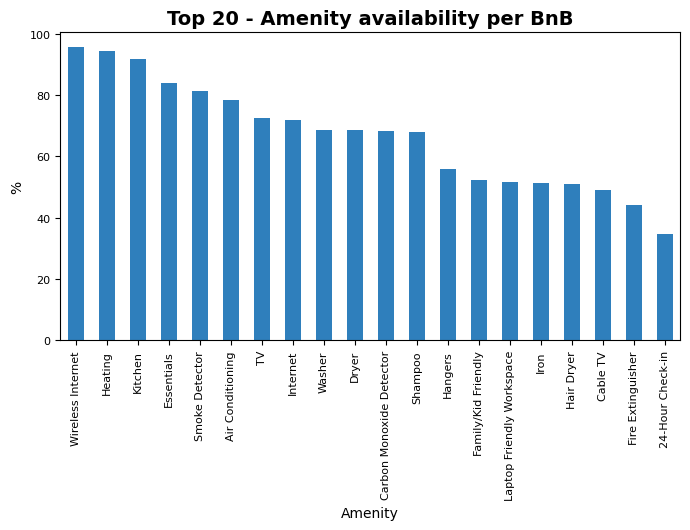

In [44]:
# Here are the the top 20 provided amenities:
plt.figure(figsize=(8,4))

amenities_availability = (100*amenities/len(listings_df))[:20]
amenities_availability.plot(kind="bar",fontsize=8,
           color = '#2F7FBC', 
           legend = False)
plt.title("Top 20 - Amenity availability per BnB", size = 14, weight = 'bold');
plt.xlabel("Amenity")
plt.ylabel("%");

## Modeling (Linear Model)

In [45]:
listings = listings_df.copy()

In [46]:
# check missing values per column
missing_values = get_column_details(listings)
missing_values[missing_values["% Missing values"]>0]

% Missing values  nunique
interaction                         43.063167     1572
access                              41.332564     1710
neighborhood_overview               39.198154     1677
host_about                          36.515720     1214
transit                             35.679262     1800
house_rules                         33.169888     1867
cleaning_fee                        30.804730       79
space                               29.679838     2183
review_scores_accuracy              22.642054        8
review_scores_location              22.613210        9
review_scores_value                 22.584367        9
review_scores_checkin               22.555524        8
review_scores_communication         22.497837        7
review_scores_cleanliness           22.497837        9
review_scores_rating                22.324776       46
first_review                        20.767234      952
last_review                         20.767234      397
reviews_per_month                   20.767234      642
neighbourhood                       15.258148       30
host_response_rate                  12.892991       52
host_response_time                  12.892991        4
host_acceptance_rate                12.892991       72
host_neighbourhood                   9.431785       53
summary                              3.576579     3021
zipcode                              1.038362       43
market                               0.403807        4
property_type                        0.086530       13
city                                 0.057687       38

In [47]:
# 1. Drop columns with high %missing values or that correlate with other columns
columns_to_drop = [
 'access',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'calendar_updated',
 'city',
 'description',
 'first_review',
 'host_about',
 'host_has_profile_pic',
 'host_listings_count',
 'host_total_listings_count',
 'host_neighbourhood',
 'host_since',
 'host_verifications',
 'house_rules',
 'interaction',
 'is_location_exact',
 'last_review',
 'latitude',
 'longitude',
 'market',
 'maximum_nights',
 'minimum_nights',
 'neighborhood_overview',
 'neighbourhood',
 'cleaning_fee',
 'review_scores_value',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'reviews_per_month',
 'smart_location',
 'space',
 'street',
 'summary',
 'transit',
 'zipcode'
]

for column in columns_to_drop:
    try:
        listings = listings.drop(columns_to_drop,axis=1)
    except:
        pass

In [48]:
# 2. Impute the mean of numeric columns

columns_numeric = get_column_details(listings,'numeric')  

columns_tofillna_mean = columns_numeric[columns_numeric["% Missing values"]>0].index

for col in columns_tofillna_mean:
    listings[col].fillna((listings[col].mean()), inplace=True)
    
    
# 3. Dummy the categorical variables

columns_categorical = get_column_details(listings,'categorical')["nunique"] 
for var in  columns_categorical.index:
    drop_first = True
    if columns_categorical[var]>2:
        drop_first = False
    
    try:
        listings = pd.concat([listings.drop(var, axis=1),
                             pd.get_dummies(listings[var], prefix=var, prefix_sep='_'
                                            , drop_first=drop_first
                                           ) ], axis=1) 
    except:
        pass
    

In [49]:
# 4. Merge listings data with calendar data
data = pd.merge(
    listings, calendar_df, how='left',
    left_on='id', right_on='listing_id',
)

data = data.drop(['price_x', 'listing_id' ], axis=1)
data = data.rename({'price_y': 'price'}, axis=1)

# Drop rows without a price value
data = data.dropna(subset=['price'])
data.Month = data.Month.astype(np.int64)

data = data.drop(["id",'date','Year_Month','available','Year','Day','DayofWeek'],axis=1)

# 5 Dummy Month column
data = pd.concat([data.drop("Month", axis=1),
                  pd.get_dummies(data["Month"], prefix="Month", prefix_sep='_' ) 
                 ]
                 , axis=1)   

In [50]:
# 6. Build Linear Model

X = data.drop("price",axis=1)
y = data.price

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lm = LinearRegression() 
lm.fit(X_train, y_train) 

# Predict 
y_test_preds = lm.predict(X_test)
y_train_preds = lm.predict(X_train)

# 7. Evaluate our model
test_r2_score = r2_score(y_test, y_test_preds)
train_r2_score = r2_score(y_train, y_train_preds)
test_mae = mean_absolute_error(y_test, y_test_preds)
train_mae = mean_absolute_error(y_train, y_train_preds)
test_rmse = mean_squared_error(y_test, y_test_preds)**0.5
train_rmse = mean_squared_error(y_train, y_train_preds)**0.5

print(f"train_r2_score = {round(train_r2_score,2)} ,test_r2_score = {round(test_r2_score,2)}")
print(f"train_MAE = {round(train_mae)} ,test_MAE = {round(test_mae)}")
print(f"train_RMSE = {round(train_rmse)} ,test_RMSE = {round(test_rmse)}")
print(f"intercept = {round(lm.intercept_)}")

train_r2_score = 0.65 ,test_r2_score = 0.64
train_MAE = 47 ,test_MAE = 47
train_RMSE = 77 ,test_RMSE = 79
intercept = 41


> 🔑 **Note:**  Our **linear model** can predict prices with a mean absolute error of `$47` (representing 30% of the median price) and explains **64%** of the variation in listing prices. 

**Create a function to plot feature coeffecients with `Plotly`**

In [68]:
def plotly_feature_coeffecients(data,x, y,x_label,y_label,title,template="plotly_dark",height=600):
    """
    Plots a bar chart using plotly
    imputs: data: a dataframe containing features and coeffecients
            x : feature column
            y : coefficients column
            x_lable,y_label : X & Y axis labels
            title: title of the graph
            template : A Plotly template 
                       possible values ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"] 
            height: height of the graph. Default =600
    """
    
    fig = px.bar(x=x, y=y,data_frame=data, 
                 template=template,
                 height=height,
                 color=y,
                 title = title,
                 labels={
                     "features": x_label,
                     "coefficients": y_label
                 }
                )
    
    fig.update_layout(
        title_text=f"<b>{title}</b>",
        title_x=0.5,
        font=dict(
            #family="Times New Roman",
            size=12,
            color="black"
        )  
    )
    fig.show();

**Feature importance (all features)**

In [52]:
# Plot feature_importance (all features)

feature_importance = pd.DataFrame(
    {'features': X.columns, 'coefficients': lm.coef_}
).sort_values(by='coefficients')
feature_importance = feature_importance.reset_index(drop=True)

feature_importance["abs_coefficients"] = np.abs(feature_importance["coefficients"])

plotly_feature_coeffecients(data=feature_importance,
                            x="features", 
                            y="coefficients",
                            x_label="features",
                            y_label="$",
                            title="Feature importance",
                            template="plotly",
                            height = 750)

***How can we use this chart to predict prices?***

First, we start with the initial price of `$41`, which is the intercept of our linear model. 

We then add and subtract all the coefficients we need.

**Price prediction example**

In [70]:
print("For example, to predict the price of a two-bedroom, one-bathroom apartment in Back Bay that we would like to rent in January, \nwe would calculate:\n")
print(f"{round(lm.intercept_)}: for the intercept")
try:
    print(f"2*{round(feature_importance[feature_importance.features.str.contains('bedrooms')]['coefficients'].iloc[0])}: for the two bedrooms")
    print(f"{round(feature_importance[feature_importance.features.str.contains('bathroom')]['coefficients'].iloc[0])}: for the bathroom")
    print(f"{round(feature_importance[feature_importance.features.str.contains('Leather District')]['coefficients'].iloc[0])}: for the Back Bay neighbourhood")
    print(f"{round(feature_importance[feature_importance.features.str.contains('Month_1')]['coefficients'].iloc[0])}: because January is the off-season")
except:
    pass

For example, to predict the price of a two-bedroom, one-bathroom apartment in Back Bay that we would like to rent in January, 
we would calculate:

41: for the intercept
2*41: for the two bedrooms
18: for the bathroom
136: for the Back Bay neighbourhood
-21: because January is the off-season


**Most important Features (Top 50)**

In [54]:
most_important_features = feature_importance.sort_values(by="abs_coefficients",ascending=False)[:50].sort_values(by="coefficients")
most_important_features.features = most_important_features.features.apply(lambda x:x.replace("property_type_",""))
most_important_features.features = most_important_features.features.apply(lambda x:x.replace("neighbourhood_cleansed_",""))
most_important_features.features = most_important_features.features.apply(lambda x:x.replace("amenities ",""))

plotly_feature_coeffecients(data=most_important_features,
                            x="features", 
                            y="coefficients",
                            x_label="",
                            y_label="$",
                            title="Most important features",
                            template="plotly",
                            height=750)

The most imporatnt features are:
* Number of bedrooms and bathrooms, 
* Neighbourhood, property type, room type and months.


* Interestingly, paid parking off premises is the second most important feature according to our model, increasing the price by almost `$71`. 

Let's plot the coefficients of amenities.


In [55]:
# select ameneties from feature_importance dataframe 
amenities_coeffecients = feature_importance[feature_importance.features.str.contains("amenities")].\
                    sort_values("coefficients",ascending=True)

plotly_feature_coeffecients(data=amenities_coeffecients,
                            x="features", 
                            y="coefficients",
                            x_label="amenities",
                            y_label="$",
                            title="Effect of amenities on price prediction",
                            template="plotly",
                            height=750)

**Features having little to no impact on price**

In [56]:
feature_importance[feature_importance.abs_coefficients<0.5]

features  coefficients  abs_coefficients
63         cancellation_policy_moderate     -0.252924          0.252924
64                         extra_people     -0.133030          0.133030
65                    number_of_reviews     -0.129214          0.129214
66                 host_acceptance_rate     -0.062516          0.062516
67  amenities Laptop Friendly Workspace     -0.038023          0.038023
68                   host_response_rate      0.274626          0.274626
69                 review_scores_rating      0.294605          0.294605

Surprisingly:
* number_of_reviews has a negative impcat on pricing (-0.13$)
* host_acceptance_rate, host_response_rate, review_scores_rating have little impact on price according to our linear model. 

We will take a closer look at reviews in the next section.

***Let's see if we can get better metrics with RandomForest model.***

## Modeling (RandomForest)

In [57]:
# Build a RandomForestRegressor Model

X = data.drop("price",axis=1)
y = data.price

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=20, n_jobs=-1) # Instantiate
rf.fit(X_train, y_train) #Fit

# Predict using our model
y_test_preds = rf.predict(X_test)
y_train_preds = rf.predict(X_train)

# Evaluate our model
test_r2_score = r2_score(y_test, y_test_preds)
train_r2_score = r2_score(y_train, y_train_preds)
test_mae = mean_absolute_error(y_test, y_test_preds)
train_mae = mean_absolute_error(y_train, y_train_preds)
test_rmse = mean_squared_error(y_test, y_test_preds)**0.5
train_rmse = mean_squared_error(y_train, y_train_preds)**0.5

print(f"train_r2_score = {round(train_r2_score,2)} ,test_r2_score = {round(test_r2_score,2)}")
print(f"train_MAE = {round(train_mae,1)} ,test_MAE = {round(test_mae,1)}")
print(f"train_RMSE = {round(train_rmse,1)} ,test_RMSE = {round(test_rmse,1)}")


train_r2_score = 0.95 ,test_r2_score = 0.93
train_MAE = 7.5 ,test_MAE = 8.4
train_RMSE = 28.5 ,test_RMSE = 35.7
intercept = 41.4


> 🔑 **Insights:**  The **RandomForset model** is much better thant our linear model.
It can predict prices with a mean absolute error of `$8` (representing 5% of the median price) and explains **93%** of the variation in listing prices. 

In [58]:
# let's plot feature importance, according to Random Forest model:

RF_feature_importances = pd.DataFrame(
    {'features': X.columns, 'coefficients': rf.feature_importances_}
    ).sort_values(by='coefficients', ascending=False)[:30]


RF_feature_importances = RF_feature_importances.sort_values(by="coefficients")

plotly_feature_coeffecients(data=RF_feature_importances,
                            x="features", 
                            y="coefficients",
                            x_label="features",
                            y_label="",
                            title="Feature importance (Random Forest)",
                            template="plotly",
                            height=750)

# 7. Question 4: What is the relation between reviews and price?

## Review scores Analysis

**price vs number_of_reviews**

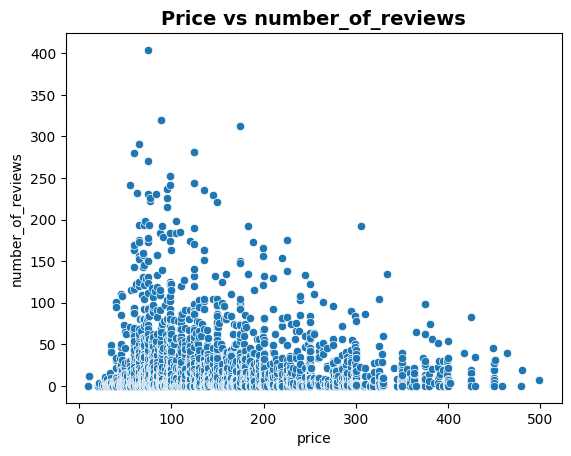

In [59]:
# Plot price vs number_of_reviews
sns.scatterplot(data=listings_df[["price","number_of_reviews"]].sort_values(by="price"),
               x="price",
               y="number_of_reviews")
plt.title("Price vs number_of_reviews", size = 14, weight = 'bold');

The graph shows that listings with prices<200$ have the most reviews.

For expensive listings, there are fewer number of reviews. 

This explains why the number of reviews has a negative coefficient in our linear model.

***Now let's plot review scores (for communication, location,...) per price range and distance to city centre.***

## Data Preparation

In [60]:
# Segment price & distance into 10 groups (10 percentiles)

bin_prices = [np.percentile(neighbourhood_price['price'],i).astype(np.int64) for  i in range(0,101,10)]
bin_distances = [np.percentile(neighbourhood_price['distance_to_downtown'],i) for i in range(0,101,10)]
bin_names = [f"{k}%" for k in range(0,91,10)]  # ['10%','20%',...90%]

neighbourhood_price['price_range'] = pd.cut(neighbourhood_price['price'],
                                            bins=bin_prices, 
                                            labels=bin_prices[:-1])

neighbourhood_price['distance_range'] = pd.cut(neighbourhood_price['distance_to_downtown'],
                                            bins=bin_distances, 
                                            labels=bin_distances[:-1])

## Result Evaluation

Evaluate review scores vs price & distance to downtown

In [61]:
# 1. Calculate Average review scores by Price Range

stats_by_PriceRange = neighbourhood_price.groupby("price_range").mean(numeric_only=True)[["price","distance_to_downtown",
                                                 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
                                                 'review_scores_checkin', 'review_scores_communication',
                                                 'review_scores_location','review_scores_value']].reset_index()

# 2. Plot Average review scores by Price Range 

fig = px.line(x='price_range', y=['review_scores_location','review_scores_communication',
                                  'review_scores_cleanliness','review_scores_rating'],
              data_frame=stats_by_PriceRange, 
              height=600,
              markers=True
             )

fig.update_layout(title_text="<b>Review Scores by price range</b>",
                  title_x=0.5, 
                  xaxis_title="Price ($)",
                  yaxis_title="score",
                  legend_title="",
                  legend=dict(
                      orientation="h",
                      yanchor="top",
                      y=-0.15,
                      xanchor="left",
                      x=0.01
                  ),                 
                  font=dict(
                          #family="Times New Roman",
                          size=14,
                          color="black"
                      )              
                 )
fig.show();

In [62]:
# 1. Calcultae review scores by Distance Range

stats_by_DistanceRange = neighbourhood_price.groupby("distance_range").mean(numeric_only=True)[["price","distance_to_downtown",
                                                 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
                                                 'review_scores_checkin', 'review_scores_communication',
                                                 'review_scores_location','review_scores_value']].reset_index()


# 2. Plot review scores by Distance Range

fig = px.line(x='distance_range', y=['review_scores_location','review_scores_communication',
                                  'review_scores_cleanliness','review_scores_rating'],
              data_frame=stats_by_DistanceRange, 
              height=650,
              markers=True
             )

fig.update_layout(title_text="<b>Review Scores by price range</b>",
                  title_x=0.5, 
                  xaxis_title="distance (Km)",
                  yaxis_title="score",
                  legend_title="",
                  legend=dict(
                      orientation="h",
                      yanchor="top",
                      y=-0.15,
                      xanchor="left",
                      x=0.01
                  ),                  
                  font=dict(
                          #family="Times New Roman",
                          size=14,
                          color="black"
                      )              
                 )
fig.show();

In [63]:
print(f"Avearge Communication review scores: {np.round(neighbourhood_price.review_scores_communication.mean(),1)}")

print(f"Avearge Location Review scores [Distance to downtown <{round(bin_distances[5],1)}Km] :\
{np.round(neighbourhood_price[neighbourhood_price.distance_to_downtown<round(bin_distances[5],1)].review_scores_location.mean(),1)}")

print(f"Avearge Location Review scores [Distance to downtown >={round(bin_distances[5],1)}Km] :\
{np.round(neighbourhood_price[neighbourhood_price.distance_to_downtown>=round(bin_distances[5],1)].review_scores_location.mean(),1)}")

print(f"Avearge Cleanliness Review scores [Price < {bin_prices[5]}$] :\
{np.round(neighbourhood_price[neighbourhood_price.price<bin_prices[5]].review_scores_cleanliness.mean(),1)}")

print(f"Avearge Cleanliness Review scores [Price >= {bin_prices[5]}$] :\
{np.round(neighbourhood_price[neighbourhood_price.price>=bin_prices[5]].review_scores_cleanliness.mean(),1)}")

Avearge Communication review scores: 9.7
Avearge Location Review scores [Distance to downtown <3.3Km] :9.7
Avearge Location Review scores [Distance to downtown >=3.3Km] :9.1
Avearge Cleanliness Review scores [Price < 147$] :9.1
Avearge Cleanliness Review scores [Price >= 147$] :9.4


* **Communication review scores:** With an average of 9.7, communication scores ares the best. Visitors are atisfied with communication, regardless of price.

* **Cleanliness review scores:** are sensitive to price. Scores are less than 9.1 for prices less than 150$ and greater than 9.4 for higer prices.

* **Location Review scores:** are sensitive to price and distance to downtown with mean value of 9.7 for distances less than 3.3 Km, and 9.1 for higher distances.



## Written reviews analysis
Most common words using Word Cloud. 

## Data Preparation

In [64]:
reviews_df.dropna(axis=0, subset=["comments"], inplace=True)

## Result Evaluation
we will use **Wordcloud** to get the most common words used to describe a property.

In [65]:
import string
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

def worldcloud_generator(reviews,background_color='black',max_words=200):    
    """
    input : reviews: a Pandas Series containg text.
    Output: 1. wordcloud
    """
    
    # 1. cleaning data
    reviews = reviews.str.lower() # apply lowercase        
    reviews = reviews.apply(lambda x: x.translate( str.maketrans('', '', string.punctuation) ) ) # Remove punctuation
    
    # 2. Tokenizing     
    # Load stopwords  
    stopwords = set(STOPWORDS)
    # join all words
    txt = ' '.join(reviews)    
    # Tokenizing
    tokens = word_tokenize(txt)
    # Removing stopwords
    text_clean = [word for word in tokens if word not in stopwords]
    
    # 3. Generating the Word Cloud
    # Generate the text
    text = ' '.join(text_clean)    
    # Create a WordCloud object
    wordcloud = WordCloud(background_color=background_color, 
                          max_words=max_words, 
                          width=700, height=500, 
                          max_font_size=500, 
                          collocations=False)
    # Generate the word cloud
    wordcloud.generate(text)

    return wordcloud
    

**Reviews Worlcloud for lowest and highest prices**

we will create two wordclouds: one for the highest prices, the other for the lowest.

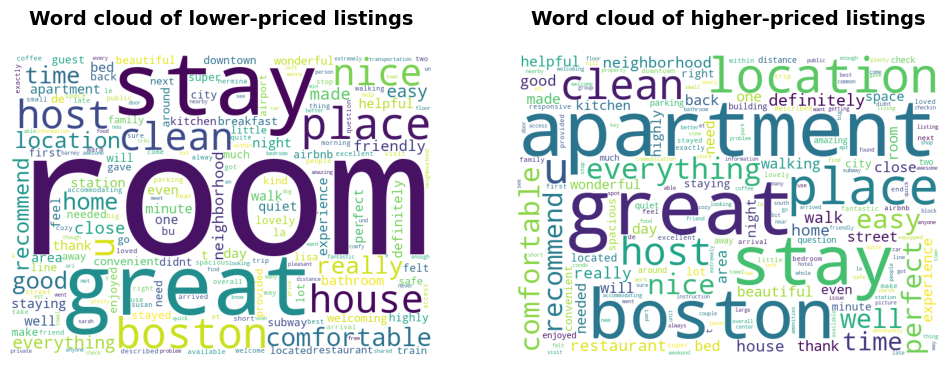

In [66]:
# 1. Worldcloud for lowest prices (prices < 25th percentile)

range_25_percentile = np.percentile(neighbourhood_price['price'],25).astype(np.int64) 
lowest_prices_ids = neighbourhood_price[neighbourhood_price.price<range_25_percentile].id
reviews_lowest_prices = reviews_df[reviews_df.listing_id.isin(lowest_prices_ids)]

worldcloud_lowest_prices = worldcloud_generator(reviews_lowest_prices.comments,
                                                background_color='white',max_words=200)


# 2. Worldcloud for Highest prices (prices > 75th percentile)

range_75_percentile = np.percentile(neighbourhood_price['price'],75).astype(np.int64) 
highest_prices_ids = neighbourhood_price[neighbourhood_price.price>range_75_percentile].id
reviews_highest_prices = reviews_df[reviews_df.listing_id.isin(highest_prices_ids)]

worldcloud_highest_prices = worldcloud_generator(reviews_highest_prices.comments,
                                                  background_color='white',max_words=200)


# 3. Plot World clouds
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(worldcloud_lowest_prices)
ax1.axis('off')
ax1.set_title("Word cloud of lower-priced listings\n", size = 14, weight = 'bold')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(worldcloud_highest_prices)
ax2.axis('off')
ax2.set_title("Word cloud of higher-priced listings\n", size = 14, weight = 'bold');

> 🔑 **Insights:** We can see that there is a lot of overlap between the two clouds. 
For example, great, nice and clean are very common words. Friendly and helpful are used by reviewers to describe their hosts.
> 
> The main difference between the two word clouds is that for high price listings, words such as perfect, great location, comfortable and highly recommend are more common, whereas for lower price listings, reviewers tend to emphasise transport with words such as station and subway.


# 8. Deployment

The main findings of the code are published [here](https://medium.com/@alaeddine.grine/insights-into-boston-airbnb-data-a418c27626d1).